In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python

In [ ]:
import os
import glob
import torch
import tifffile as tiff
import logging
from PIL import Image
import os, random
from matplotlib import pyplot as plt

Domain A image shape: (512, 512)
Domain B image shape: (512, 512, 3)


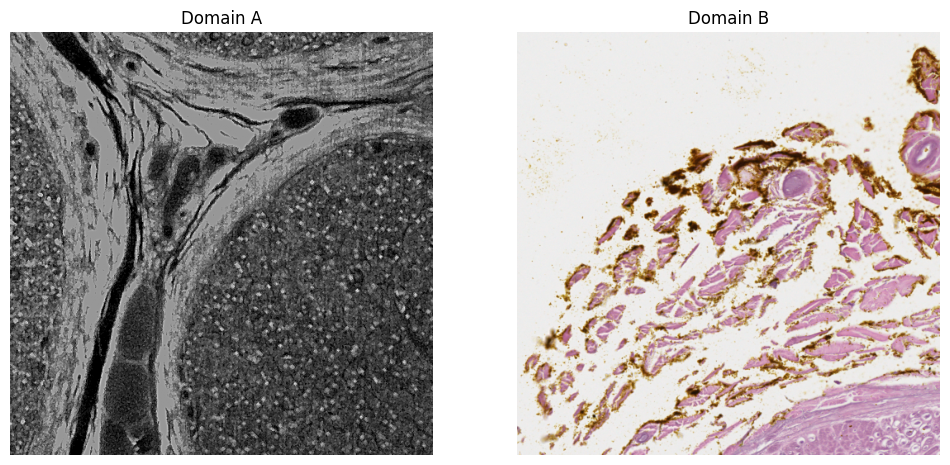

In [ ]:
import os
import random
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import img_as_float


def list_valid_files(root, extensions=('.tif', '.tiff', '.png', '.jpg', '.jpeg')):
    """Return a sorted list of files in `root` matching the given extensions."""
    return sorted([
        os.path.join(root, f)
        for f in os.listdir(root)
        if f.lower().endswith(extensions)
    ])

def choose_random_file(files):
    """Randomly select and return one file from the list."""
    if not files:
        raise ValueError("No valid files found.")
    return random.choice(files)


def load_image(file_path):
    """Load an image using tifffile."""
    return tiff.imread(file_path)

def select_random_slice(img):
    """
    If the image is a stack (either grayscale (N, H, W) or RGB (N, H, W, 3)),
    return a random slice. Otherwise, return the image as is.
    """
    if img.ndim == 3:
        # For a 3D image, check if last dimension is 3 (RGB) or not.
        if img.shape[-1] == 3:
            # It's a single RGB image.
            return img
        else:
            # Grayscale stack.
            idx = random.randint(0, img.shape[0] - 1)
            return img[idx]
    elif img.ndim == 4 and img.shape[-1] == 3:
        # RGB stack.
        idx = random.randint(0, img.shape[0] - 1)
        return img[idx]
    else:
        # Already a single image.
        return img


def normalize_image(img):
    """
    Normalize image to [0,1]. If integer type, use dtype maximum;
    if floating and outside [0,1], scale accordingly.
    """
    if np.issubdtype(img.dtype, np.integer):
        max_val = np.iinfo(img.dtype).max
        return img.astype(np.float32) / max_val
    elif np.issubdtype(img.dtype, np.floating):
        if img.max() > 1.0:
            return img / img.max()
    return img


def get_unpaired_images(root_A, root_B, transform=None):
    """
    Randomly selects and returns one image from Domain A and one from Domain B.
    If an image file is a stack, a random slice is selected.
    The image is normalized to [0,1]. Optionally, a transform can be applied.
    """
    # List and choose files.
    files_A = list_valid_files(root_A)
    files_B = list_valid_files(root_B)

    file_A = choose_random_file(files_A)
    file_B = choose_random_file(files_B)

    # Load images.
    img_A = load_image(file_A)
    img_B = load_image(file_B)

    # Select a random slice if necessary.
    img_A = select_random_slice(img_A)
    img_B = select_random_slice(img_B)

    # Normalize.
    img_A = normalize_image(img_A)
    img_B = normalize_image(img_B)

    # Apply transform if provided.
    if transform:
        img_A = transform(img_A)
        img_B = transform(img_B)

    return img_A, img_B


if __name__ == "__main__":
    domain_A_img = '/content/drive/MyDrive/CycleGAN/split_dataset_A/train/'
    domain_B_img = '/content/drive/MyDrive/CycleGAN/split_dataset_B/train/'

    img_A, img_B = get_unpaired_images(domain_A_img, domain_B_img)

    print("Domain A image shape:", img_A.shape)
    print("Domain B image shape:", img_B.shape)

    # Plot images side-by-side.
    plt.figure(figsize=(12,9))

    plt.subplot(1,2,1)
    if img_A.ndim == 2:
        plt.imshow(img_A, cmap='gray')
    else:
        plt.imshow(img_A)
    plt.title("Domain A")
    plt.axis("off")

    plt.subplot(1,2,2)
    if img_B.ndim == 2:
        plt.imshow(img_B, cmap='gray')
    else:
        plt.imshow(img_B)
    plt.title("Domain B")
    plt.axis("off")

    plt.show()


In [ ]:
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

class TiffToRGB:
    def __call__(self, image, **kwargs):
        """
        Convert a TIFF image (as a NumPy array) to a standard RGB image.
          - If 16-bit, scales to [0,1].
          - If the image is grayscale (2D) or has a single channel, replicates the channel to get RGB.
          - If the image is a stack (e.g. shape (N, H, W)) for grayscale, selects a random slice and replicates it.
          - If the image has more than 3 channels, selects the first 3.
        Returns a float NumPy array in [0,1].
        """
        # If 16-bit, scale to [0,1].
        if image.dtype == np.uint16:
            image = image.astype(np.float32) / 65535.0

        # Handle dimensions:
        if image.ndim == 2:
            # Single grayscale image.
            image = np.stack([image] * 3, axis=-1)
        elif image.ndim == 3:
            # Could be either a single image or a stack.
            # Check the size of the last dimension.
            if image.shape[-1] == 1:
                # Single-channel image; replicate channels.
                image = np.concatenate([image] * 3, axis=-1)
            elif image.shape[-1] == 3:
                # Likely a single RGB image.
                pass
            else:
                # If the last dimension is not 1 or 3, assume it's a stack of grayscale images with shape (N, H, W).
                # Select a random slice.
                idx = random.randint(0, image.shape[0] - 1)
                image = image[idx]
                # Now image is 2D; replicate channels.
                image = np.stack([image] * 3, axis=-1)
        elif image.ndim == 4 and image.shape[-1] == 3:
            # RGB stack: randomly select one slice.
            idx = random.randint(0, image.shape[0] - 1)
            image = image[idx]
        else:
            raise ValueError("Unexpected image shape.")

        # Do not convert back to uint8; keep as float in [0,1].
        return image



# Pipeline for Domain A: originally grayscale (converted to RGB) and normalized (ImageNet stats).
transform_A = A.Compose([
    A.Lambda(image=TiffToRGB()),  # Custom TIFF-to-RGB conversion.
    ToTensorV2(),
])

# Pipeline for Domain B: already RGB; no normalization applied.
transform_B = A.Compose([
    A.Lambda(image=TiffToRGB()),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
from torch.utils.data import Dataset, DataLoader
import os, random
import tifffile as tiff

def load_images_from_folder(root, extensions=('.tif', '.tiff')):
    """
    Loads all images from the folder and returns a list.
    """
    files = sorted([
        os.path.join(root, f)
        for f in os.listdir(root)
        if f.lower().endswith(extensions)
    ])
    images = [tiff.imread(f) for f in files]
    return images

class UnpairedTiffDataset(Dataset):
    def __init__(self, images_A, images_B, transform_A=None, transform_B=None):
        """
        Args:
            images_A (list): Preloaded images for Domain A.
            images_B (list): Preloaded images for Domain B.
            transform_A (callable, optional): Transformation for Domain A images.
            transform_B (callable, optional): Transformation for Domain B images.
        """
        self.images_A = images_A
        self.images_B = images_B
        self.transform_A = transform_A
        self.transform_B = transform_B
        self.len_A = len(self.images_A)
        self.len_B = len(self.images_B)
        self.length = max(self.len_A, self.len_B)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        # Cycle through Domain A images and randomly select one from Domain B.
        img_A = self.images_A[index % self.len_A]
        img_B = random.choice(self.images_B)

        if self.transform_A:
            img_A = self.transform_A(image=img_A)['image']
        if self.transform_B:
            img_B = self.transform_B(image=img_B)['image']
        return img_A, img_B

# Example usage:
domain_A_train = '/content/drive/MyDrive/CycleGAN/split_dataset_A/train/'
domain_B_train = '/content/drive/MyDrive/CycleGAN/split_dataset_B/train/'

# Preload images from each directory.
images_A = load_images_from_folder(domain_A_train)
images_B = load_images_from_folder(domain_B_train)


Batch Domain A shape: torch.Size([16, 3, 512, 512])
Batch Domain B shape: torch.Size([16, 3, 512, 512])


In [ ]:
# Create the dataset using preloaded images.
train_dataset = UnpairedTiffDataset(images_A, images_B, transform_A=transform_A, transform_B=transform_B)
# Create DataLoader.
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)  # num_workers=0 since data is in memory

In [ ]:
domain_A_val = '/content/drive/MyDrive/CycleGAN/split_dataset_A/val/'
domain_B_val = '/content/drive/MyDrive/CycleGAN/split_dataset_B/val/'
# Preload images from each directory.
images_A_val = load_images_from_folder(domain_A_val)
images_B_val = load_images_from_folder(domain_B_val)
# Create the dataset using preloaded images.
val_dataset = UnpairedTiffDataset(images_A_val, images_B_val, transform_A=transform_A, transform_B=transform_B)
# Create DataLoader.
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=0)

In [ ]:
domain_A_test = '/content/drive/MyDrive/CycleGAN/split_dataset_A/test/'
domain_B_test = '/content/drive/MyDrive/CycleGAN/split_dataset_B/test/'
# Preload images from each directory.
images_A_test = load_images_from_folder(domain_A_test)
images_B_test = load_images_from_folder(domain_B_test)
# Create the dataset using preloaded images.
test_dataset = UnpairedTiffDataset(images_A_test, images_B_test, transform_A=transform_A, transform_B=transform_B)
# Create DataLoader.
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

Sample Domain A image shape: torch.Size([3, 512, 512])
Sample Domain B image shape: torch.Size([3, 512, 512])


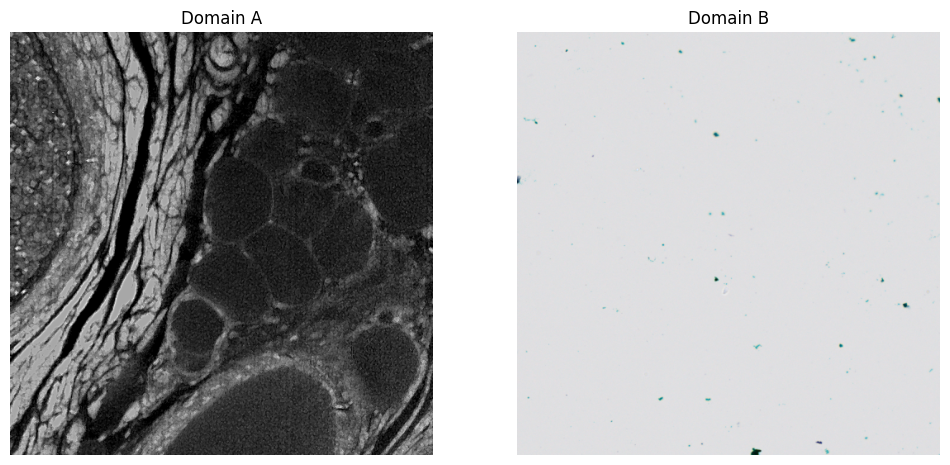

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def to_channel_last(image):
    # If the image is in CxHxW and the first dimension is 3, convert it to HxWxC.
    if image.ndim == 3 and image.shape[0] == 3:
        return np.transpose(image, (1, 2, 0))
    return image

sample_A, sample_B = train_dataset[50]
print("Sample Domain A image shape:", sample_A.shape)
print("Sample Domain B image shape:", sample_B.shape)
sample_A_disp = to_channel_last(sample_A)
sample_B_disp = to_channel_last(sample_B)

plt.figure(figsize=(12,9))
plt.subplot(1,2,1)
if sample_A_disp.ndim == 2:
    plt.imshow(sample_A_disp, cmap='gray')
else:
    plt.imshow(sample_A_disp)
plt.title("Domain A")
plt.axis("off")

plt.subplot(1,2,2)
if sample_B_disp.ndim == 2:
    plt.imshow(sample_B_disp, cmap='gray')
else:
    plt.imshow(sample_B_disp)
plt.title("Domain B")
plt.axis("off")
plt.show()


In [ ]:
print("Total train batches:", len(train_loader))
print("Total validation batches:", len(val_loader))
print("Total test batches:", len(test_loader))

Total train batches: 72
Total validation batches: 16
Total test batches: 16


Domain A batch shape: torch.Size([4, 3, 512, 512])
Domain B batch shape: torch.Size([4, 3, 512, 512])


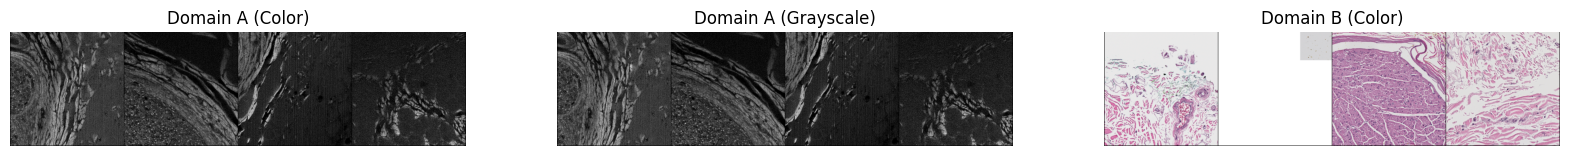

In [ ]:
from torchvision.utils import make_grid
# Fetch one batch.
batch_A, batch_B = next(iter(train_loader))
print("Domain A batch shape:", batch_A.shape)
print("Domain B batch shape:", batch_B.shape)

# Create grids for visualization.
grid_A = make_grid(batch_A, nrow=4)
grid_A_gray = grid_A.float().mean(dim=0)
grid_B = make_grid(batch_B, nrow=4)

# Plotting the results.
plt.figure(figsize=(20, 10))

# Plot Domain A (color)
plt.subplot(1, 3, 1)
plt.imshow(grid_A.permute(1, 2, 0).cpu().numpy())
plt.title("Domain A (Color)")
plt.axis("off")

# Plot Domain A as grayscale.
plt.subplot(1, 3, 2)
plt.imshow(grid_A_gray.cpu().numpy(), cmap='gray')
plt.title("Domain A (Grayscale)")
plt.axis("off")

# Plot Domain B (color).
plt.subplot(1, 3, 3)
plt.imshow(grid_B.permute(1, 2, 0).cpu().numpy())
plt.title("Domain B (Color)")
plt.axis("off")

plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create checkpoint directory
save_dir = "/content/drive/MyDrive/GAN/checkpoints"
os.makedirs(save_dir, exist_ok=True)


Using device: cuda


In [ ]:
# Residual Block for the generator.
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

# Generator: ResNet-based.
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9):
        super(ResnetGenerator, self).__init__()
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        # Downsampling
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        # Residual blocks
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult)]

        # Upsampling
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2, padding=1, output_padding=1),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# Discriminator: 70x70 PatchGAN.
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super(NLayerDiscriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]
        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]
        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]
        self.model = nn.Sequential(*sequence)

    def forward(self, x):
        return self.model(x)

# CycleGAN model: bundles two generators and two discriminators.
class CycleGAN(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9):
        super(CycleGAN, self).__init__()
        # According to UPIT docs, forward returns (fake_A, fake_B, idt_A, idt_B)
        # Here, we define:
        # fake_A: output of G_B(real_B) for B→A
        # fake_B: output of G_A(real_A) for A→B
        # idt_A: identity output when real_A is fed to G_B
        # idt_B: identity output when real_B is fed to G_A
        self.G_A = ResnetGenerator(input_nc, output_nc, ngf, n_blocks)  # A->B
        self.G_B = ResnetGenerator(input_nc, output_nc, ngf, n_blocks)  # B->A
        self.D_A = NLayerDiscriminator(input_nc)
        self.D_B = NLayerDiscriminator(input_nc)

    def forward(self, inputs):
        real_A, real_B = inputs
        # Generate fake images.
        fake_B = self.G_A(real_A)  # A→B output.
        fake_A = self.G_B(real_B)  # B→A output.
        # Identity mapping.
        idt_A = self.G_B(real_A)   # For domain A, should be near real_A.
        idt_B = self.G_A(real_B)   # For domain B, should be near real_B.
        return fake_A, fake_B, idt_A, idt_B


In [ ]:
import torch
import torch.nn as nn

class AdversarialLoss(nn.Module):
    def __init__(self):
        super(AdversarialLoss, self).__init__()
        self.loss = nn.MSELoss()

    def forward(self, pred, target_is_real):
        target = torch.ones_like(pred, device=pred.device) if target_is_real else torch.zeros_like(pred, device=pred.device)
        return self.loss(pred, target)

class CycleGANLoss(nn.Module):
    def __init__(self, lambda_cycle=10.0, lambda_idt=0.5):
        """
        Combines adversarial, cycle consistency, and identity losses.

        Args:
          lambda_cycle (float): Weight for cycle consistency loss.
          lambda_idt (float): Weight for identity loss.
        """
        super(CycleGANLoss, self).__init__()
        self.lambda_cycle = lambda_cycle
        self.lambda_idt = lambda_idt
        self.adv_loss = AdversarialLoss()   # Adversarial loss (LSGAN using MSELoss)
        self.cycle_loss = nn.L1Loss()         # Cycle consistency loss
        self.identity_loss = nn.L1Loss()      # Identity loss

    def forward(self, outputs, targets, D_fake_A=None, D_fake_B=None):
        """
        Compute the full generator loss.

        Args:
            outputs (tuple): Contains six tensors:
                (fake_A, fake_B, idt_A, idt_B, cycle_A, cycle_B)
                where:
                  - fake_A: output of G_B(real_B) for B→A.
                  - fake_B: output of G_A(real_A) for A→B.
                  - idt_A: identity output when real_A is fed to G_B.
                  - idt_B: identity output when real_B is fed to G_A.
                  - cycle_A: reconstructed image of real_A via cycle (G_B(G_A(real_A))).
                  - cycle_B: reconstructed image of real_B via cycle (G_A(G_B(real_B))).
            targets (tuple): (real_A, real_B).
            D_fake_A (tensor, optional): Discriminator prediction for fake_A (from D_A).
            D_fake_B (tensor, optional): Discriminator prediction for fake_B (from D_B).

        Returns:
            total_loss (tensor): Weighted sum of adversarial, cycle, and identity losses.
        """
        fake_A, fake_B, idt_A, idt_B, cycle_A, cycle_B = outputs
        real_A, real_B = targets

        # Identity loss: enforce that G_B(real_A) ~ real_A and G_A(real_B) ~ real_B.
        id_loss_A = self.identity_loss(idt_A, real_A)
        id_loss_B = self.identity_loss(idt_B, real_B)
        identity_loss = id_loss_A + id_loss_B

        # Cycle consistency loss.
        cycle_loss_A = self.cycle_loss(cycle_A, real_A)
        cycle_loss_B = self.cycle_loss(cycle_B, real_B)
        cycle_loss = cycle_loss_A + cycle_loss_B

        # Adversarial loss for generators.
        # For the generator, we want the discriminator to think the fakes are real.
        adv_loss_A = self.adv_loss(D_fake_A, True) if D_fake_A is not None else 0
        adv_loss_B = self.adv_loss(D_fake_B, True) if D_fake_B is not None else 0
        adv_loss = adv_loss_A + adv_loss_B

        total_loss = adv_loss + self.lambda_cycle * cycle_loss + self.lambda_idt * identity_loss
        return total_loss


Epoch [1/200] Batch [0/72] - Gen Loss: 22.6693 (Adv: 2.5790, Cycle: 13.0865, Id: 6.5227) | Disc Loss: 1.5782 (D_A: 0.6602, D_B: 0.9179)
Epoch [1/200] Batch [10/72] - Gen Loss: 4.5308 (Adv: 1.9845, Cycle: 5.7531, Id: 2.9234) | Disc Loss: 0.5233 (D_A: 0.2564, D_B: 0.2670)
Epoch [1/200] Batch [20/72] - Gen Loss: 4.0767 (Adv: 1.3622, Cycle: 4.3237, Id: 2.1428) | Disc Loss: 0.5123 (D_A: 0.2394, D_B: 0.2728)
Epoch [1/200] Batch [30/72] - Gen Loss: 4.4026 (Adv: 1.1774, Cycle: 3.8802, Id: 1.8672) | Disc Loss: 0.5462 (D_A: 0.2967, D_B: 0.2495)
Epoch [1/200] Batch [40/72] - Gen Loss: 3.8397 (Adv: 1.1052, Cycle: 3.4856, Id: 1.6680) | Disc Loss: 0.4433 (D_A: 0.2116, D_B: 0.2317)
Epoch [1/200] Batch [50/72] - Gen Loss: 3.6363 (Adv: 1.0438, Cycle: 3.3280, Id: 1.5816) | Disc Loss: 0.5002 (D_A: 0.2740, D_B: 0.2262)
Epoch [1/200] Batch [60/72] - Gen Loss: 3.5303 (Adv: 1.0035, Cycle: 3.1739, Id: 1.5073) | Disc Loss: 0.4189 (D_A: 0.2300, D_B: 0.1889)
Epoch [1/200] Batch [70/72] - Gen Loss: 3.7924 (Adv: 0

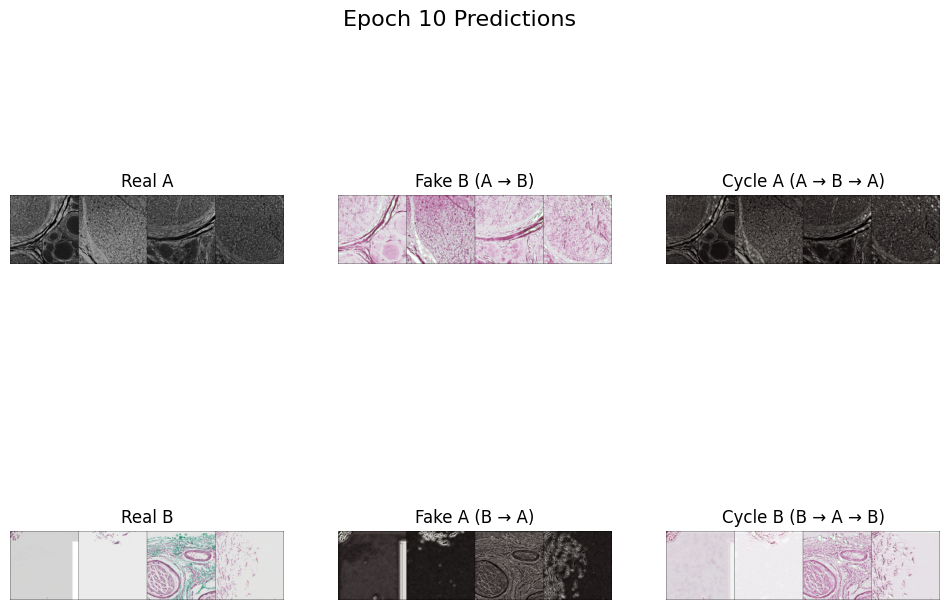

Epoch [11/200] Batch [0/72] - Gen Loss: 5.8412 (Adv: 1.8409, Cycle: 3.5044, Id: 1.7267) | Disc Loss: 0.3989 (D_A: 0.2191, D_B: 0.1798)
Epoch [11/200] Batch [10/72] - Gen Loss: 6.5785 (Adv: 1.3977, Cycle: 1.9967, Id: 0.9599) | Disc Loss: 0.3194 (D_A: 0.0879, D_B: 0.2315)
Epoch [11/200] Batch [20/72] - Gen Loss: 3.1081 (Adv: 1.3743, Cycle: 1.8957, Id: 0.8914) | Disc Loss: 0.4682 (D_A: 0.3069, D_B: 0.1613)
Epoch [11/200] Batch [30/72] - Gen Loss: 2.9273 (Adv: 1.2708, Cycle: 1.8650, Id: 0.8796) | Disc Loss: 0.3182 (D_A: 0.1227, D_B: 0.1955)
Epoch [11/200] Batch [40/72] - Gen Loss: 2.7044 (Adv: 1.2212, Cycle: 1.8610, Id: 0.8766) | Disc Loss: 0.4370 (D_A: 0.1748, D_B: 0.2622)
Epoch [11/200] Batch [50/72] - Gen Loss: 2.5784 (Adv: 1.2125, Cycle: 1.8811, Id: 0.8915) | Disc Loss: 0.3926 (D_A: 0.1620, D_B: 0.2305)
Epoch [11/200] Batch [60/72] - Gen Loss: 3.2266 (Adv: 1.2059, Cycle: 1.8966, Id: 0.9048) | Disc Loss: 0.4447 (D_A: 0.1742, D_B: 0.2705)
Epoch [11/200] Batch [70/72] - Gen Loss: 3.2527 (

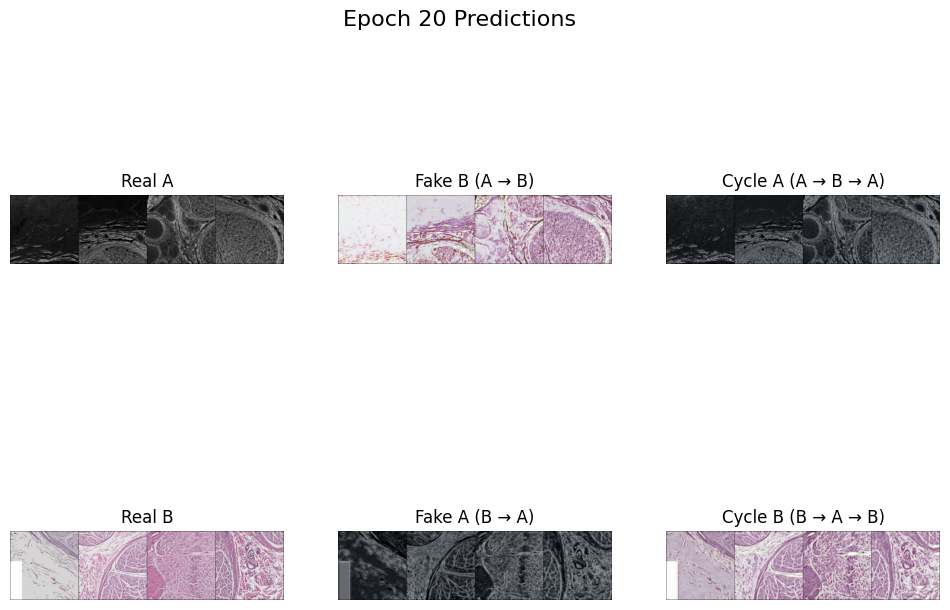

Epoch [21/200] Batch [0/72] - Gen Loss: 3.0738 (Adv: 1.1589, Cycle: 1.4160, Id: 0.5537) | Disc Loss: 0.4452 (D_A: 0.3166, D_B: 0.1286)
Epoch [21/200] Batch [10/72] - Gen Loss: 3.1106 (Adv: 1.3781, Cycle: 2.0378, Id: 0.9629) | Disc Loss: 0.3508 (D_A: 0.1698, D_B: 0.1810)
Epoch [21/200] Batch [20/72] - Gen Loss: 2.8817 (Adv: 1.4781, Cycle: 1.8585, Id: 0.8627) | Disc Loss: 0.3399 (D_A: 0.1038, D_B: 0.2360)
Epoch [21/200] Batch [30/72] - Gen Loss: 5.4472 (Adv: 1.4921, Cycle: 1.8722, Id: 0.8835) | Disc Loss: 0.4635 (D_A: 0.2614, D_B: 0.2021)
Epoch [21/200] Batch [40/72] - Gen Loss: 2.8992 (Adv: 1.4464, Cycle: 1.7166, Id: 0.8095) | Disc Loss: 0.2242 (D_A: 0.1081, D_B: 0.1160)
Epoch [21/200] Batch [50/72] - Gen Loss: 3.9454 (Adv: 1.4531, Cycle: 1.8417, Id: 0.8589) | Disc Loss: 0.3980 (D_A: 0.1200, D_B: 0.2780)
Epoch [21/200] Batch [60/72] - Gen Loss: 3.2621 (Adv: 1.4534, Cycle: 1.7755, Id: 0.8281) | Disc Loss: 0.2166 (D_A: 0.0643, D_B: 0.1523)
Epoch [21/200] Batch [70/72] - Gen Loss: 2.8205 (

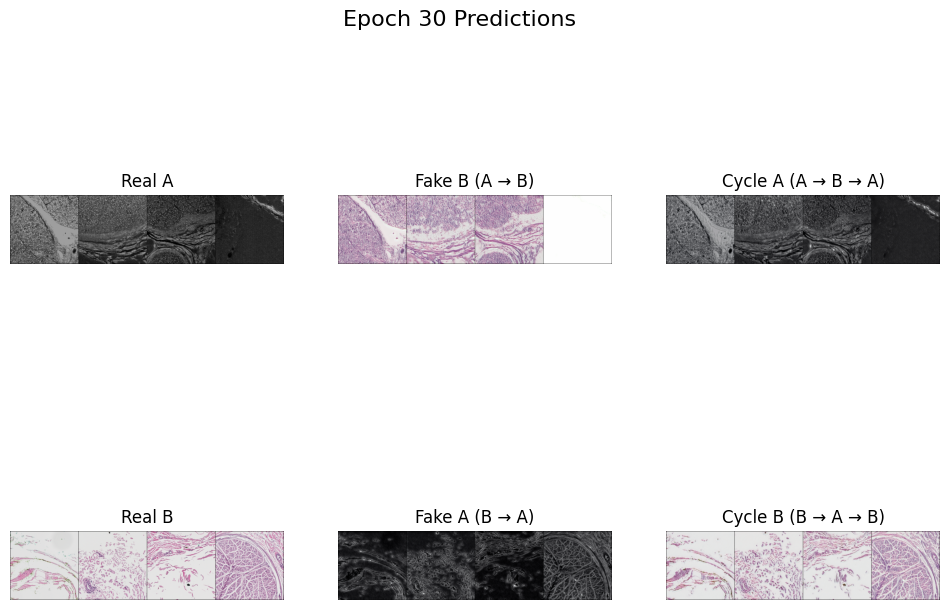

Epoch [31/200] Batch [0/72] - Gen Loss: 2.5509 (Adv: 0.9828, Cycle: 1.1603, Id: 0.5131) | Disc Loss: 0.5014 (D_A: 0.2231, D_B: 0.2783)
Epoch [31/200] Batch [10/72] - Gen Loss: 2.9707 (Adv: 1.3420, Cycle: 1.9749, Id: 0.9135) | Disc Loss: 0.2503 (D_A: 0.0685, D_B: 0.1818)
Epoch [31/200] Batch [20/72] - Gen Loss: 2.3724 (Adv: 1.4317, Cycle: 1.6279, Id: 0.7503) | Disc Loss: 0.1881 (D_A: 0.0831, D_B: 0.1050)
Epoch [31/200] Batch [30/72] - Gen Loss: 2.5386 (Adv: 1.4546, Cycle: 1.5314, Id: 0.7111) | Disc Loss: 0.4401 (D_A: 0.2562, D_B: 0.1840)
Epoch [31/200] Batch [40/72] - Gen Loss: 3.0391 (Adv: 1.4234, Cycle: 1.5856, Id: 0.7177) | Disc Loss: 0.2236 (D_A: 0.1163, D_B: 0.1073)
Epoch [31/200] Batch [50/72] - Gen Loss: 2.4560 (Adv: 1.4192, Cycle: 1.5745, Id: 0.7054) | Disc Loss: 0.4366 (D_A: 0.2192, D_B: 0.2174)
Epoch [31/200] Batch [60/72] - Gen Loss: 3.2389 (Adv: 1.3984, Cycle: 1.5987, Id: 0.7192) | Disc Loss: 0.3826 (D_A: 0.1231, D_B: 0.2595)
Epoch [31/200] Batch [70/72] - Gen Loss: 2.4126 (

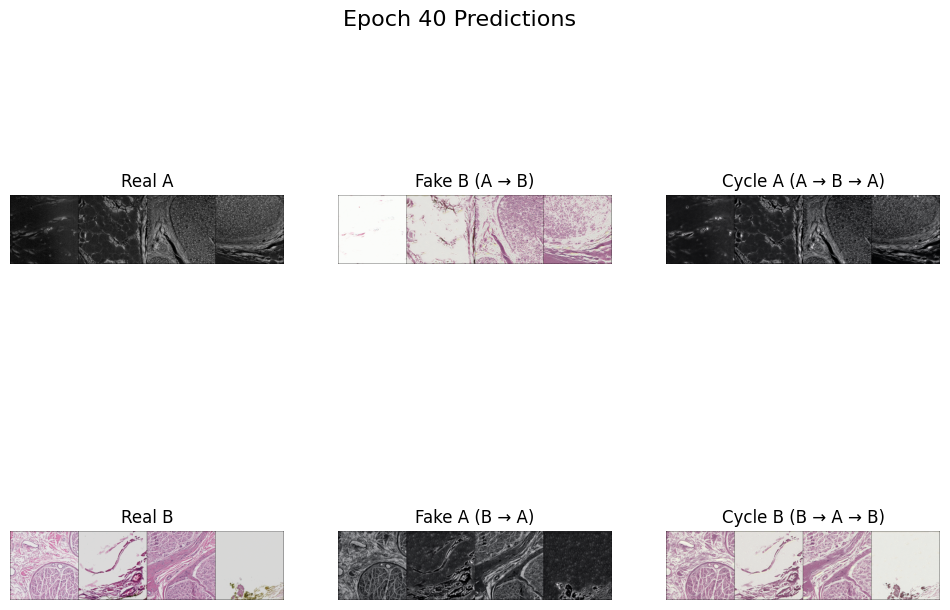

Epoch [41/200] Batch [0/72] - Gen Loss: 5.5801 (Adv: 1.5780, Cycle: 2.9648, Id: 1.4122) | Disc Loss: 0.2258 (D_A: 0.1242, D_B: 0.1016)
Epoch [41/200] Batch [10/72] - Gen Loss: 1.9321 (Adv: 1.3777, Cycle: 1.2804, Id: 0.5596) | Disc Loss: 0.5386 (D_A: 0.3432, D_B: 0.1954)
Epoch [41/200] Batch [20/72] - Gen Loss: 2.5343 (Adv: 1.3087, Cycle: 1.4961, Id: 0.6872) | Disc Loss: 0.3065 (D_A: 0.1302, D_B: 0.1763)
Epoch [41/200] Batch [30/72] - Gen Loss: 2.2643 (Adv: 1.2627, Cycle: 1.3466, Id: 0.6129) | Disc Loss: 0.2309 (D_A: 0.0703, D_B: 0.1606)
Epoch [41/200] Batch [40/72] - Gen Loss: 2.2759 (Adv: 1.2719, Cycle: 1.3100, Id: 0.5915) | Disc Loss: 0.3240 (D_A: 0.1060, D_B: 0.2180)
Epoch [41/200] Batch [50/72] - Gen Loss: 2.9379 (Adv: 1.3016, Cycle: 1.2985, Id: 0.5861) | Disc Loss: 0.4328 (D_A: 0.2088, D_B: 0.2240)
Epoch [41/200] Batch [60/72] - Gen Loss: 2.7297 (Adv: 1.2967, Cycle: 1.3977, Id: 0.6387) | Disc Loss: 0.3921 (D_A: 0.1177, D_B: 0.2743)
Epoch [41/200] Batch [70/72] - Gen Loss: 2.0468 (

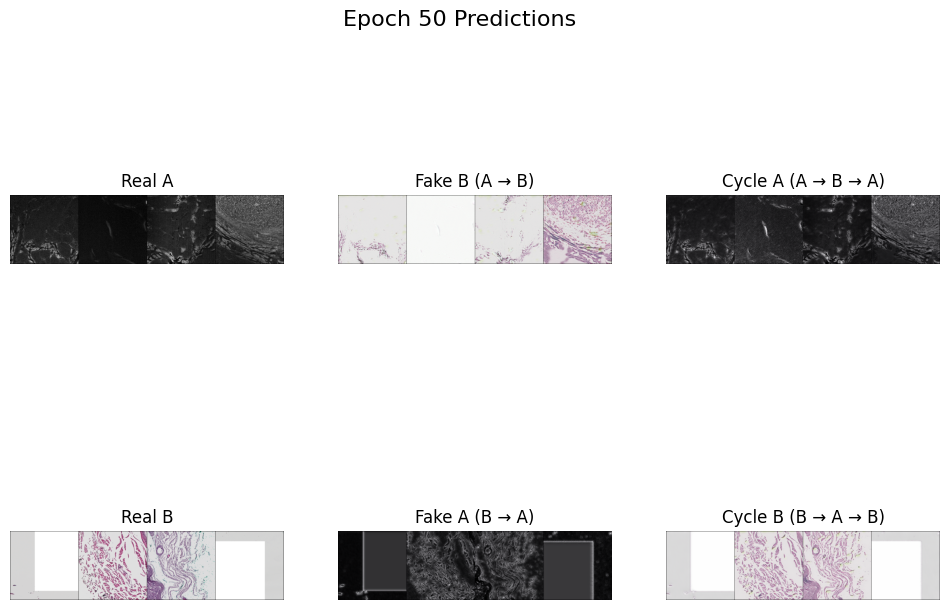

Epoch [51/200] Batch [0/72] - Gen Loss: 2.2968 (Adv: 1.0604, Cycle: 1.0740, Id: 0.4590) | Disc Loss: 0.3175 (D_A: 0.1189, D_B: 0.1986)
Epoch [51/200] Batch [10/72] - Gen Loss: 5.2560 (Adv: 1.3528, Cycle: 1.1987, Id: 0.5321) | Disc Loss: 0.3900 (D_A: 0.0545, D_B: 0.3355)
Epoch [51/200] Batch [20/72] - Gen Loss: 1.7400 (Adv: 1.3354, Cycle: 1.1518, Id: 0.5005) | Disc Loss: 0.4912 (D_A: 0.2376, D_B: 0.2537)
Epoch [51/200] Batch [30/72] - Gen Loss: 2.5290 (Adv: 1.3108, Cycle: 1.2541, Id: 0.5588) | Disc Loss: 0.3877 (D_A: 0.1642, D_B: 0.2235)
Epoch [51/200] Batch [40/72] - Gen Loss: 3.0489 (Adv: 1.3026, Cycle: 1.3366, Id: 0.6026) | Disc Loss: 0.4882 (D_A: 0.2774, D_B: 0.2108)
Epoch [51/200] Batch [50/72] - Gen Loss: 2.0786 (Adv: 1.3077, Cycle: 1.3171, Id: 0.5920) | Disc Loss: 0.2221 (D_A: 0.1027, D_B: 0.1193)
Epoch [51/200] Batch [60/72] - Gen Loss: 2.1766 (Adv: 1.3338, Cycle: 1.3069, Id: 0.5862) | Disc Loss: 0.2702 (D_A: 0.1469, D_B: 0.1232)
Epoch [51/200] Batch [70/72] - Gen Loss: 2.5352 (

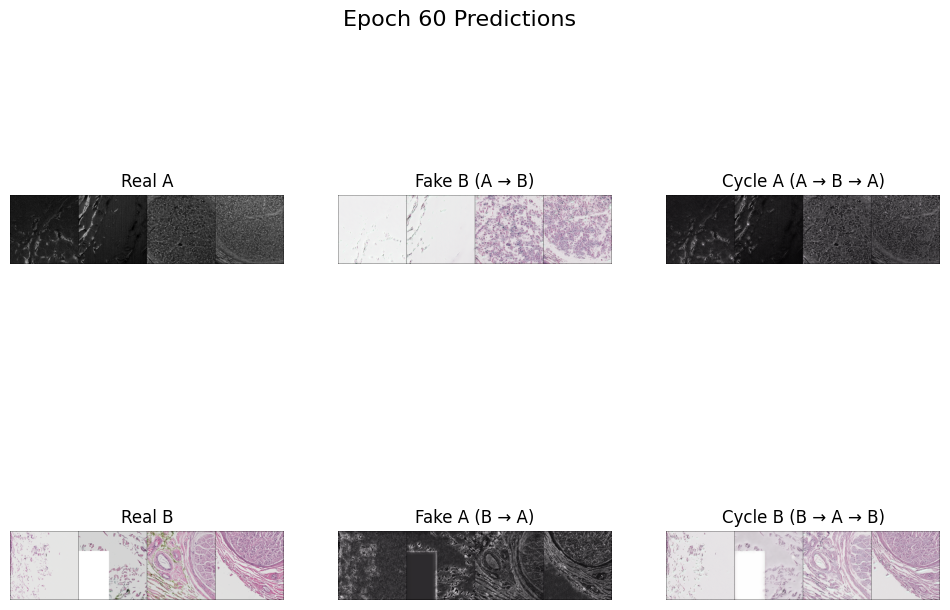

Epoch [61/200] Batch [0/72] - Gen Loss: 2.0788 (Adv: 1.2981, Cycle: 0.7789, Id: 0.3707) | Disc Loss: 0.2778 (D_A: 0.1318, D_B: 0.1460)
Epoch [61/200] Batch [10/72] - Gen Loss: 2.1540 (Adv: 1.3195, Cycle: 1.1230, Id: 0.5008) | Disc Loss: 0.4902 (D_A: 0.2093, D_B: 0.2809)
Epoch [61/200] Batch [20/72] - Gen Loss: 5.2876 (Adv: 1.3072, Cycle: 1.1284, Id: 0.4993) | Disc Loss: 0.4024 (D_A: 0.1547, D_B: 0.2477)
Epoch [61/200] Batch [30/72] - Gen Loss: 1.9734 (Adv: 1.2719, Cycle: 1.1527, Id: 0.5070) | Disc Loss: 0.3594 (D_A: 0.1619, D_B: 0.1975)
Epoch [61/200] Batch [40/72] - Gen Loss: 2.1899 (Adv: 1.3127, Cycle: 1.2407, Id: 0.5522) | Disc Loss: 0.2245 (D_A: 0.0614, D_B: 0.1631)
Epoch [61/200] Batch [50/72] - Gen Loss: 3.4597 (Adv: 1.3405, Cycle: 1.2468, Id: 0.5534) | Disc Loss: 0.2209 (D_A: 0.0551, D_B: 0.1658)
Epoch [61/200] Batch [60/72] - Gen Loss: 2.4342 (Adv: 1.3375, Cycle: 1.2697, Id: 0.5648) | Disc Loss: 0.2749 (D_A: 0.0660, D_B: 0.2088)
Epoch [61/200] Batch [70/72] - Gen Loss: 2.5564 (

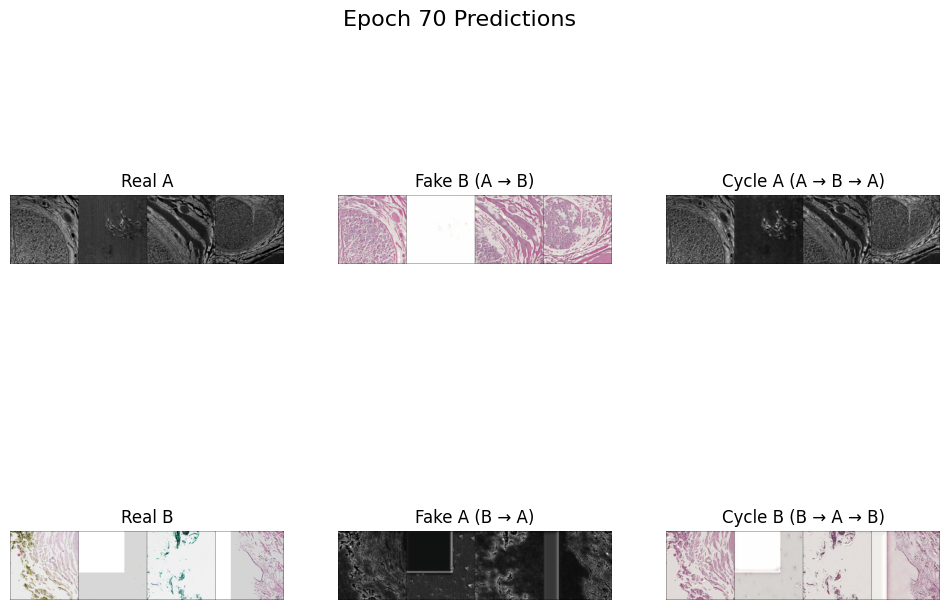

Epoch [71/200] Batch [0/72] - Gen Loss: 2.5313 (Adv: 1.3359, Cycle: 1.1848, Id: 0.5047) | Disc Loss: 0.3001 (D_A: 0.1602, D_B: 0.1399)
Epoch [71/200] Batch [10/72] - Gen Loss: 3.0736 (Adv: 1.3790, Cycle: 1.5288, Id: 0.6731) | Disc Loss: 0.1973 (D_A: 0.0386, D_B: 0.1587)
Epoch [71/200] Batch [20/72] - Gen Loss: 7.3802 (Adv: 1.3541, Cycle: 1.6384, Id: 0.7304) | Disc Loss: 0.2160 (D_A: 0.0352, D_B: 0.1807)
Epoch [71/200] Batch [30/72] - Gen Loss: 2.6530 (Adv: 1.3657, Cycle: 1.5830, Id: 0.7043) | Disc Loss: 0.2776 (D_A: 0.1081, D_B: 0.1695)
Epoch [71/200] Batch [40/72] - Gen Loss: 2.3220 (Adv: 1.3267, Cycle: 1.4798, Id: 0.6574) | Disc Loss: 0.3122 (D_A: 0.1288, D_B: 0.1834)
Epoch [71/200] Batch [50/72] - Gen Loss: 2.5676 (Adv: 1.3187, Cycle: 1.3751, Id: 0.6081) | Disc Loss: 0.2949 (D_A: 0.0765, D_B: 0.2184)
Epoch [71/200] Batch [60/72] - Gen Loss: 4.6995 (Adv: 1.3107, Cycle: 1.3650, Id: 0.6019) | Disc Loss: 0.4419 (D_A: 0.2292, D_B: 0.2128)
Epoch [71/200] Batch [70/72] - Gen Loss: 2.3955 (

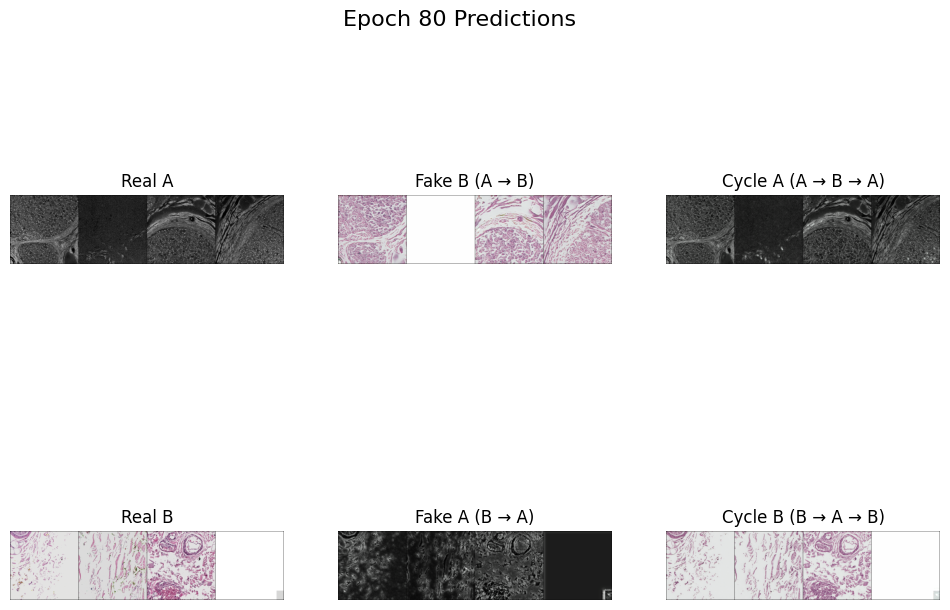

Epoch [81/200] Batch [0/72] - Gen Loss: 1.9573 (Adv: 0.5411, Cycle: 0.9161, Id: 0.4195) | Disc Loss: 0.4826 (D_A: 0.2645, D_B: 0.2181)
Epoch [81/200] Batch [10/72] - Gen Loss: 1.9036 (Adv: 0.8258, Cycle: 1.0989, Id: 0.4725) | Disc Loss: 0.4687 (D_A: 0.2340, D_B: 0.2347)
Epoch [81/200] Batch [20/72] - Gen Loss: 2.0193 (Adv: 0.9172, Cycle: 0.9656, Id: 0.4123) | Disc Loss: 0.4347 (D_A: 0.2170, D_B: 0.2177)
Epoch [81/200] Batch [30/72] - Gen Loss: 1.9557 (Adv: 0.9158, Cycle: 1.1298, Id: 0.4929) | Disc Loss: 0.4825 (D_A: 0.2750, D_B: 0.2075)
Epoch [81/200] Batch [40/72] - Gen Loss: 2.2970 (Adv: 0.9506, Cycle: 1.2234, Id: 0.5420) | Disc Loss: 0.2909 (D_A: 0.1424, D_B: 0.1486)
Epoch [81/200] Batch [50/72] - Gen Loss: 1.9827 (Adv: 0.9619, Cycle: 1.2296, Id: 0.5461) | Disc Loss: 0.4968 (D_A: 0.2341, D_B: 0.2627)
Epoch [81/200] Batch [60/72] - Gen Loss: 1.7951 (Adv: 0.9596, Cycle: 1.2020, Id: 0.5358) | Disc Loss: 0.4019 (D_A: 0.1966, D_B: 0.2054)
Epoch [81/200] Batch [70/72] - Gen Loss: 4.6536 (

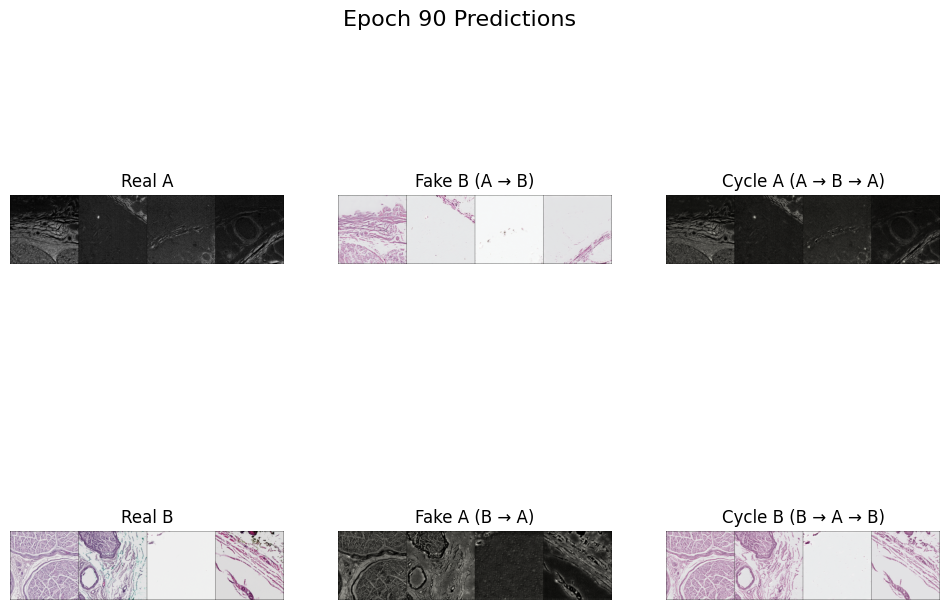

Epoch [91/200] Batch [0/72] - Gen Loss: 4.8794 (Adv: 1.1729, Cycle: 2.6575, Id: 1.0991) | Disc Loss: 0.4058 (D_A: 0.0520, D_B: 0.3539)
Epoch [91/200] Batch [10/72] - Gen Loss: 2.6117 (Adv: 1.3138, Cycle: 1.4239, Id: 0.6283) | Disc Loss: 0.2255 (D_A: 0.0879, D_B: 0.1376)
Epoch [91/200] Batch [20/72] - Gen Loss: 2.2289 (Adv: 1.3742, Cycle: 1.3482, Id: 0.5948) | Disc Loss: 0.3993 (D_A: 0.1350, D_B: 0.2643)
Epoch [91/200] Batch [30/72] - Gen Loss: 2.2633 (Adv: 1.3379, Cycle: 1.4038, Id: 0.6129) | Disc Loss: 0.3874 (D_A: 0.2326, D_B: 0.1548)
Epoch [91/200] Batch [40/72] - Gen Loss: 2.3435 (Adv: 1.3078, Cycle: 1.3381, Id: 0.5822) | Disc Loss: 0.3339 (D_A: 0.1052, D_B: 0.2287)
Epoch [91/200] Batch [50/72] - Gen Loss: 2.2377 (Adv: 1.3247, Cycle: 1.2680, Id: 0.5516) | Disc Loss: 0.5062 (D_A: 0.2699, D_B: 0.2363)
Epoch [91/200] Batch [60/72] - Gen Loss: 2.6028 (Adv: 1.2884, Cycle: 1.2722, Id: 0.5527) | Disc Loss: 0.1899 (D_A: 0.0501, D_B: 0.1398)
Epoch [91/200] Batch [70/72] - Gen Loss: 2.5012 (

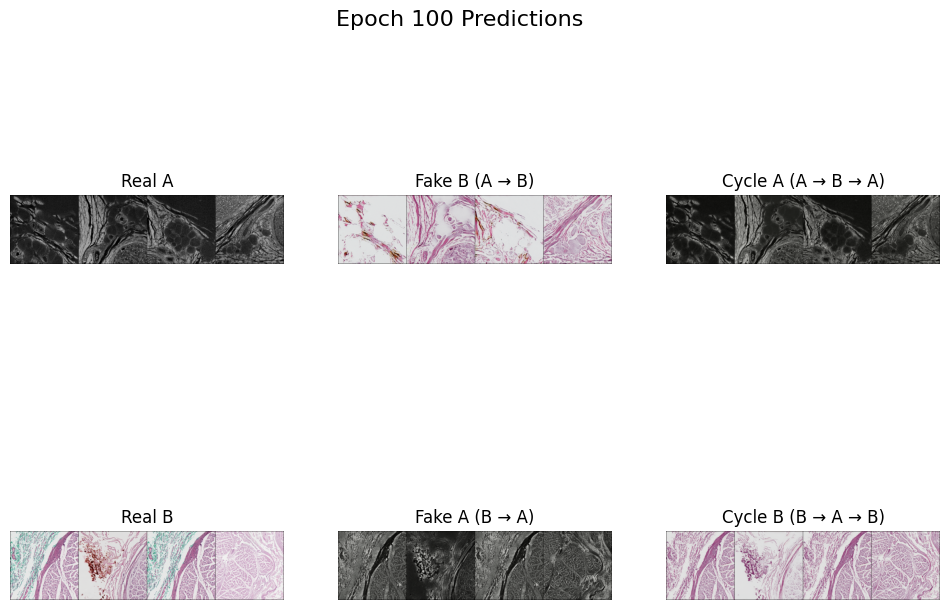

Epoch [101/200] Batch [0/72] - Gen Loss: 2.5571 (Adv: 1.3695, Cycle: 0.9223, Id: 0.3959) | Disc Loss: 0.2453 (D_A: 0.0585, D_B: 0.1869)
Epoch [101/200] Batch [10/72] - Gen Loss: 1.6462 (Adv: 1.2425, Cycle: 0.8712, Id: 0.3695) | Disc Loss: 0.5210 (D_A: 0.2803, D_B: 0.2407)
Epoch [101/200] Batch [20/72] - Gen Loss: 1.7358 (Adv: 1.2396, Cycle: 0.9652, Id: 0.4152) | Disc Loss: 0.3808 (D_A: 0.1678, D_B: 0.2131)
Epoch [101/200] Batch [30/72] - Gen Loss: 1.9511 (Adv: 1.1536, Cycle: 0.9840, Id: 0.4261) | Disc Loss: 0.3637 (D_A: 0.1666, D_B: 0.1971)
Epoch [101/200] Batch [40/72] - Gen Loss: 2.7397 (Adv: 1.1988, Cycle: 1.0624, Id: 0.4678) | Disc Loss: 0.3483 (D_A: 0.0945, D_B: 0.2538)
Epoch [101/200] Batch [50/72] - Gen Loss: 2.0847 (Adv: 1.2207, Cycle: 1.0826, Id: 0.4747) | Disc Loss: 0.3469 (D_A: 0.0965, D_B: 0.2504)
Epoch [101/200] Batch [60/72] - Gen Loss: 1.8227 (Adv: 1.2181, Cycle: 1.0723, Id: 0.4699) | Disc Loss: 0.5249 (D_A: 0.3093, D_B: 0.2156)
Epoch [101/200] Batch [70/72] - Gen Loss: 

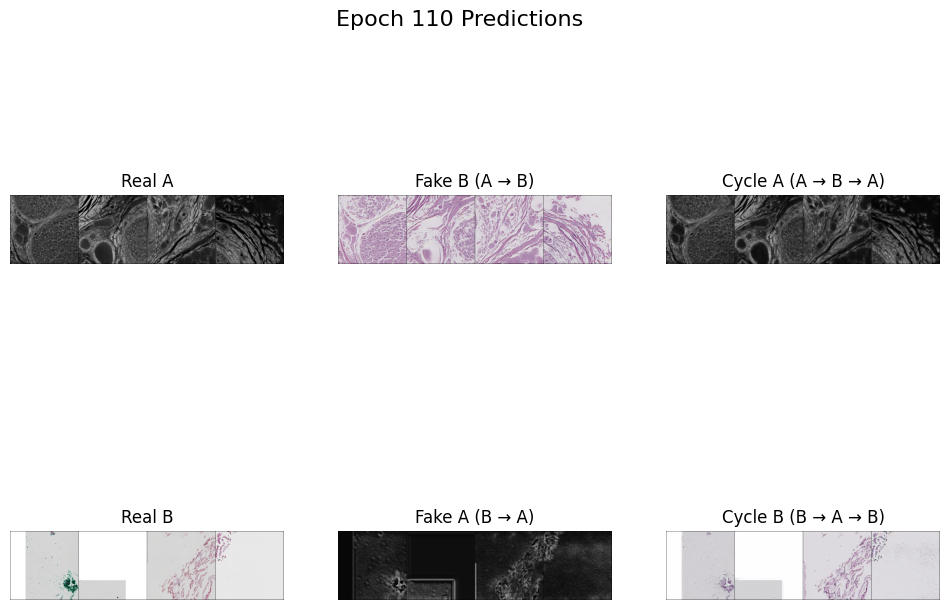

Epoch [111/200] Batch [0/72] - Gen Loss: 1.9957 (Adv: 1.3625, Cycle: 1.0443, Id: 0.4843) | Disc Loss: 0.3940 (D_A: 0.2274, D_B: 0.1667)
Epoch [111/200] Batch [10/72] - Gen Loss: 2.4599 (Adv: 1.3417, Cycle: 1.3934, Id: 0.5940) | Disc Loss: 0.2795 (D_A: 0.0283, D_B: 0.2512)
Epoch [111/200] Batch [20/72] - Gen Loss: 2.8303 (Adv: 1.3026, Cycle: 1.3494, Id: 0.5902) | Disc Loss: 0.3386 (D_A: 0.1205, D_B: 0.2181)
Epoch [111/200] Batch [30/72] - Gen Loss: 1.7249 (Adv: 1.3244, Cycle: 1.2490, Id: 0.5425) | Disc Loss: 0.4441 (D_A: 0.1169, D_B: 0.3272)
Epoch [111/200] Batch [40/72] - Gen Loss: 2.2972 (Adv: 1.3064, Cycle: 1.1919, Id: 0.5207) | Disc Loss: 0.2797 (D_A: 0.0847, D_B: 0.1950)
Epoch [111/200] Batch [50/72] - Gen Loss: 3.0727 (Adv: 1.2564, Cycle: 1.2706, Id: 0.5577) | Disc Loss: 0.3784 (D_A: 0.0838, D_B: 0.2946)
Epoch [111/200] Batch [60/72] - Gen Loss: 1.7643 (Adv: 1.2629, Cycle: 1.2094, Id: 0.5265) | Disc Loss: 0.3150 (D_A: 0.1547, D_B: 0.1602)
Epoch [111/200] Batch [70/72] - Gen Loss: 

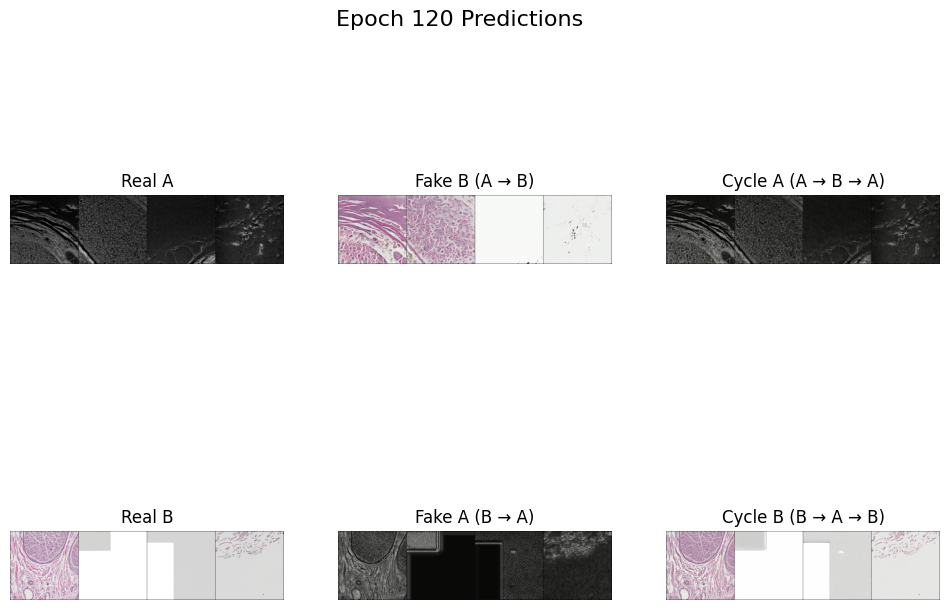

Epoch [121/200] Batch [0/72] - Gen Loss: 2.1014 (Adv: 1.2859, Cycle: 0.8702, Id: 0.3741) | Disc Loss: 0.2820 (D_A: 0.0859, D_B: 0.1960)
Epoch [121/200] Batch [10/72] - Gen Loss: 2.0969 (Adv: 1.1747, Cycle: 1.4705, Id: 0.6591) | Disc Loss: 0.2627 (D_A: 0.1212, D_B: 0.1415)
Epoch [121/200] Batch [20/72] - Gen Loss: 1.8074 (Adv: 1.1951, Cycle: 1.3198, Id: 0.5848) | Disc Loss: 0.2988 (D_A: 0.1274, D_B: 0.1714)
Epoch [121/200] Batch [30/72] - Gen Loss: 2.3953 (Adv: 1.2297, Cycle: 1.1747, Id: 0.5105) | Disc Loss: 0.2833 (D_A: 0.0628, D_B: 0.2206)
Epoch [121/200] Batch [40/72] - Gen Loss: 3.1067 (Adv: 1.2398, Cycle: 1.1290, Id: 0.4912) | Disc Loss: 0.3526 (D_A: 0.1540, D_B: 0.1986)
Epoch [121/200] Batch [50/72] - Gen Loss: 1.6233 (Adv: 1.2070, Cycle: 1.1407, Id: 0.4931) | Disc Loss: 0.3473 (D_A: 0.1738, D_B: 0.1734)
Epoch [121/200] Batch [60/72] - Gen Loss: 2.7947 (Adv: 1.2085, Cycle: 1.1753, Id: 0.5077) | Disc Loss: 0.4744 (D_A: 0.2623, D_B: 0.2121)
Epoch [121/200] Batch [70/72] - Gen Loss: 

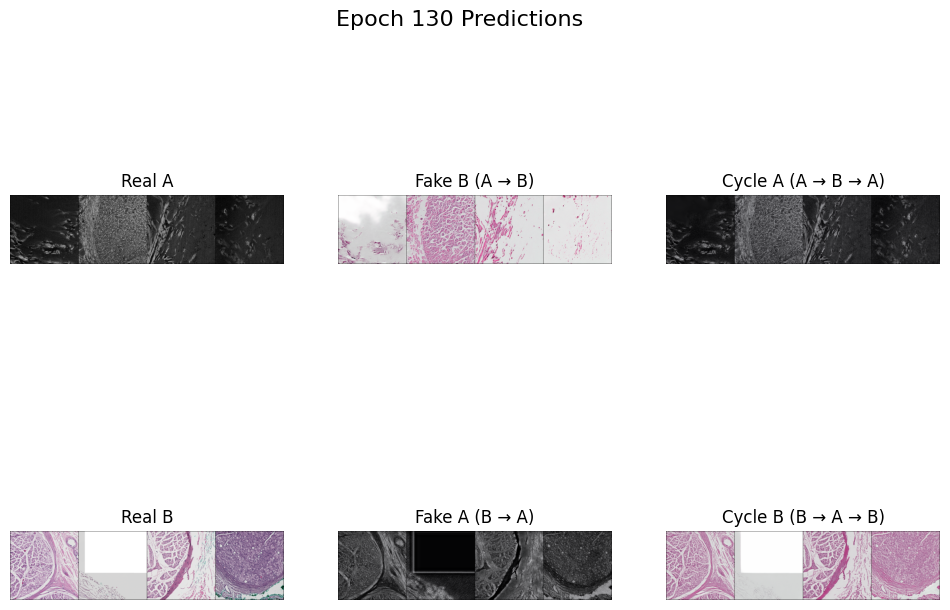

Epoch [131/200] Batch [0/72] - Gen Loss: 3.0046 (Adv: 1.2764, Cycle: 0.8619, Id: 0.3352) | Disc Loss: 0.2977 (D_A: 0.1002, D_B: 0.1975)
Epoch [131/200] Batch [10/72] - Gen Loss: 2.1178 (Adv: 1.2178, Cycle: 1.2628, Id: 0.5441) | Disc Loss: 0.3725 (D_A: 0.0628, D_B: 0.3098)
Epoch [131/200] Batch [20/72] - Gen Loss: 1.6564 (Adv: 1.3083, Cycle: 1.2242, Id: 0.5162) | Disc Loss: 0.3660 (D_A: 0.1609, D_B: 0.2051)
Epoch [131/200] Batch [30/72] - Gen Loss: 2.2373 (Adv: 1.2634, Cycle: 1.2021, Id: 0.5099) | Disc Loss: 0.3933 (D_A: 0.1612, D_B: 0.2321)
Epoch [131/200] Batch [40/72] - Gen Loss: 2.6272 (Adv: 1.2406, Cycle: 1.1876, Id: 0.5028) | Disc Loss: 0.3300 (D_A: 0.1160, D_B: 0.2140)
Epoch [131/200] Batch [50/72] - Gen Loss: 2.0327 (Adv: 1.2384, Cycle: 1.2013, Id: 0.5096) | Disc Loss: 0.5086 (D_A: 0.2395, D_B: 0.2690)
Epoch [131/200] Batch [60/72] - Gen Loss: 1.5746 (Adv: 1.2143, Cycle: 1.1665, Id: 0.4923) | Disc Loss: 0.4334 (D_A: 0.1953, D_B: 0.2381)
Epoch [131/200] Batch [70/72] - Gen Loss: 

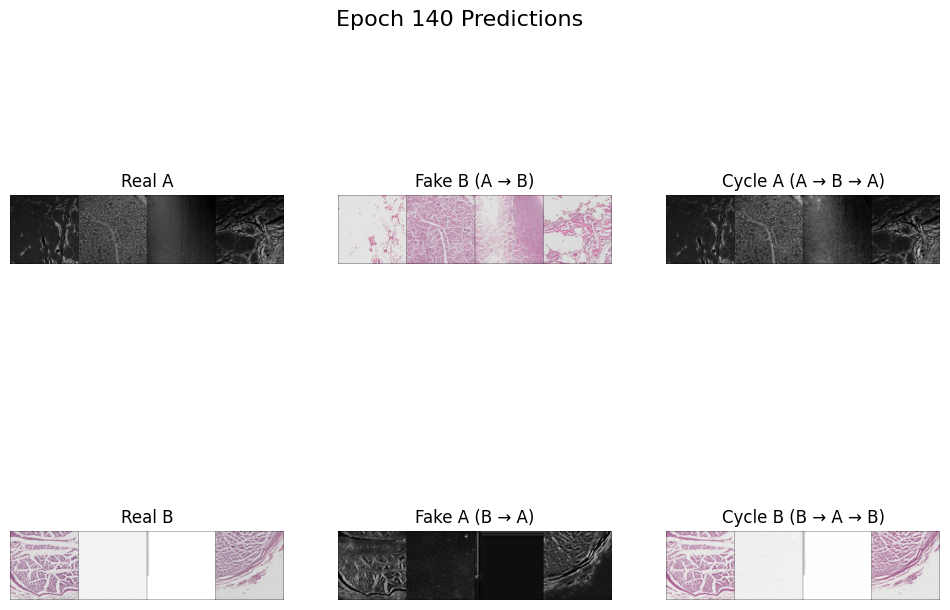

Epoch [141/200] Batch [0/72] - Gen Loss: 2.4518 (Adv: 1.5110, Cycle: 1.0092, Id: 0.4454) | Disc Loss: 0.4043 (D_A: 0.1957, D_B: 0.2086)
Epoch [141/200] Batch [10/72] - Gen Loss: 1.8268 (Adv: 1.1453, Cycle: 1.0603, Id: 0.4613) | Disc Loss: 0.3969 (D_A: 0.1951, D_B: 0.2018)
Epoch [141/200] Batch [20/72] - Gen Loss: 1.8864 (Adv: 1.1376, Cycle: 1.0822, Id: 0.4663) | Disc Loss: 0.4662 (D_A: 0.2528, D_B: 0.2134)
Epoch [141/200] Batch [30/72] - Gen Loss: 3.7574 (Adv: 1.1428, Cycle: 1.1189, Id: 0.4825) | Disc Loss: 0.3536 (D_A: 0.1193, D_B: 0.2343)
Epoch [141/200] Batch [40/72] - Gen Loss: 4.4103 (Adv: 1.1397, Cycle: 1.1273, Id: 0.4889) | Disc Loss: 0.2845 (D_A: 0.0940, D_B: 0.1905)
Epoch [141/200] Batch [50/72] - Gen Loss: 4.3365 (Adv: 1.1352, Cycle: 1.1241, Id: 0.4847) | Disc Loss: 0.3308 (D_A: 0.0871, D_B: 0.2438)
Epoch [141/200] Batch [60/72] - Gen Loss: 1.9384 (Adv: 1.1548, Cycle: 1.1209, Id: 0.4796) | Disc Loss: 0.4099 (D_A: 0.1768, D_B: 0.2330)
Epoch [141/200] Batch [70/72] - Gen Loss: 

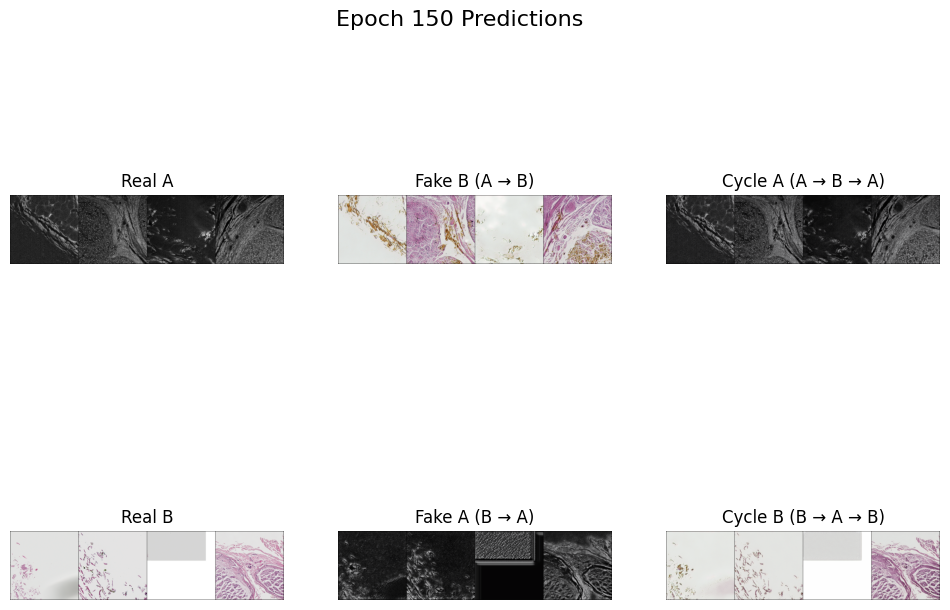

Epoch [151/200] Batch [0/72] - Gen Loss: 1.8112 (Adv: 1.5257, Cycle: 0.8182, Id: 0.3249) | Disc Loss: 0.3671 (D_A: 0.1656, D_B: 0.2014)
Epoch [151/200] Batch [10/72] - Gen Loss: 3.7304 (Adv: 1.3178, Cycle: 1.1519, Id: 0.4994) | Disc Loss: 0.2873 (D_A: 0.1536, D_B: 0.1338)
Epoch [151/200] Batch [20/72] - Gen Loss: 3.0555 (Adv: 1.2572, Cycle: 1.0194, Id: 0.4284) | Disc Loss: 0.3593 (D_A: 0.1105, D_B: 0.2488)
Epoch [151/200] Batch [30/72] - Gen Loss: 2.8510 (Adv: 1.2804, Cycle: 0.9954, Id: 0.4083) | Disc Loss: 0.2682 (D_A: 0.0724, D_B: 0.1958)
Epoch [151/200] Batch [40/72] - Gen Loss: 1.9798 (Adv: 1.2665, Cycle: 1.1020, Id: 0.4636) | Disc Loss: 0.3044 (D_A: 0.1257, D_B: 0.1787)
Epoch [151/200] Batch [50/72] - Gen Loss: 3.7848 (Adv: 1.2552, Cycle: 1.1083, Id: 0.4680) | Disc Loss: 0.2624 (D_A: 0.1258, D_B: 0.1366)
Epoch [151/200] Batch [60/72] - Gen Loss: 5.8687 (Adv: 1.2454, Cycle: 1.2102, Id: 0.5195) | Disc Loss: 0.3239 (D_A: 0.1213, D_B: 0.2026)
Epoch [151/200] Batch [70/72] - Gen Loss: 

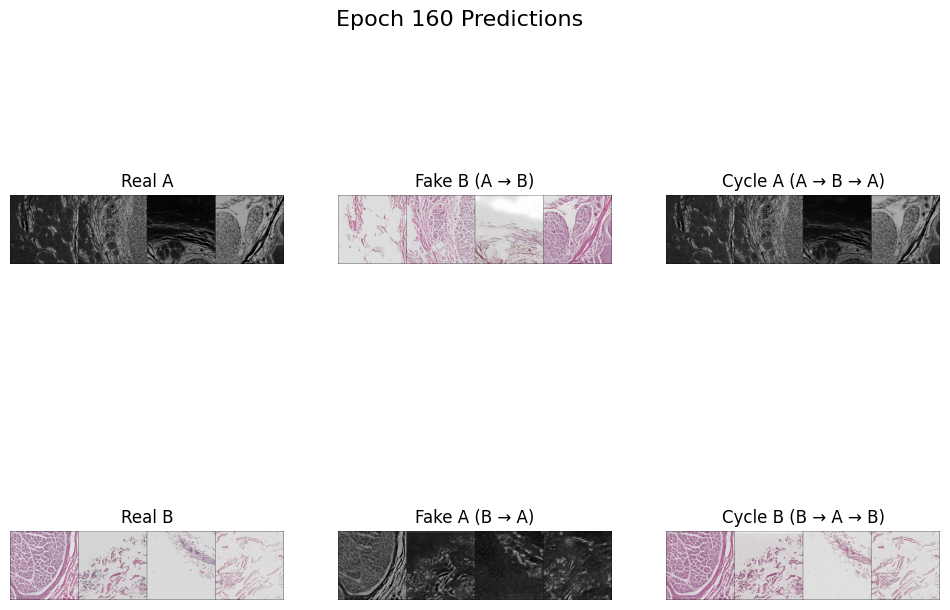

Epoch [161/200] Batch [0/72] - Gen Loss: 2.5173 (Adv: 1.1501, Cycle: 0.8081, Id: 0.3093) | Disc Loss: 0.3033 (D_A: 0.0850, D_B: 0.2183)
Epoch [161/200] Batch [10/72] - Gen Loss: 3.6827 (Adv: 1.2239, Cycle: 1.0142, Id: 0.4170) | Disc Loss: 0.3524 (D_A: 0.1174, D_B: 0.2350)
Epoch [161/200] Batch [20/72] - Gen Loss: 3.9110 (Adv: 1.2144, Cycle: 1.0169, Id: 0.4270) | Disc Loss: 0.3695 (D_A: 0.1061, D_B: 0.2634)
Epoch [161/200] Batch [30/72] - Gen Loss: 2.3194 (Adv: 1.2029, Cycle: 1.0806, Id: 0.4371) | Disc Loss: 0.3445 (D_A: 0.1582, D_B: 0.1863)
Epoch [161/200] Batch [40/72] - Gen Loss: 1.6030 (Adv: 1.1782, Cycle: 1.1069, Id: 0.4558) | Disc Loss: 0.5199 (D_A: 0.2548, D_B: 0.2650)
Epoch [161/200] Batch [50/72] - Gen Loss: 2.3115 (Adv: 1.1778, Cycle: 1.0694, Id: 0.4392) | Disc Loss: 0.3088 (D_A: 0.1312, D_B: 0.1775)
Epoch [161/200] Batch [60/72] - Gen Loss: 1.8763 (Adv: 1.1807, Cycle: 1.0674, Id: 0.4379) | Disc Loss: 0.4504 (D_A: 0.2346, D_B: 0.2158)
Epoch [161/200] Batch [70/72] - Gen Loss: 

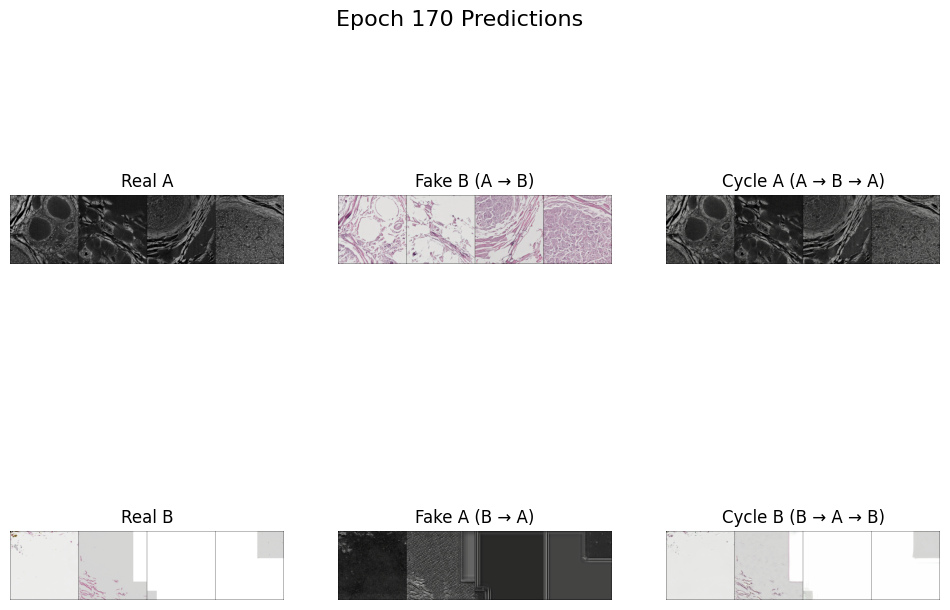

Epoch [171/200] Batch [0/72] - Gen Loss: 2.1341 (Adv: 1.4771, Cycle: 0.7575, Id: 0.3099) | Disc Loss: 0.4048 (D_A: 0.1259, D_B: 0.2788)
Epoch [171/200] Batch [10/72] - Gen Loss: 2.0853 (Adv: 1.1535, Cycle: 0.9466, Id: 0.4106) | Disc Loss: 0.3579 (D_A: 0.1620, D_B: 0.1958)
Epoch [171/200] Batch [20/72] - Gen Loss: 1.8834 (Adv: 1.0956, Cycle: 0.9181, Id: 0.3833) | Disc Loss: 0.4361 (D_A: 0.1993, D_B: 0.2369)
Epoch [171/200] Batch [30/72] - Gen Loss: 1.9753 (Adv: 1.1113, Cycle: 0.9037, Id: 0.3742) | Disc Loss: 0.2891 (D_A: 0.1325, D_B: 0.1566)
Epoch [171/200] Batch [40/72] - Gen Loss: 2.1639 (Adv: 1.1327, Cycle: 0.8649, Id: 0.3582) | Disc Loss: 0.2071 (D_A: 0.0839, D_B: 0.1232)
Epoch [171/200] Batch [50/72] - Gen Loss: 1.6047 (Adv: 1.1407, Cycle: 0.8849, Id: 0.3670) | Disc Loss: 0.3703 (D_A: 0.1770, D_B: 0.1933)
Epoch [171/200] Batch [60/72] - Gen Loss: 1.6456 (Adv: 1.1567, Cycle: 0.8614, Id: 0.3550) | Disc Loss: 0.3448 (D_A: 0.1918, D_B: 0.1530)
Epoch [171/200] Batch [70/72] - Gen Loss: 

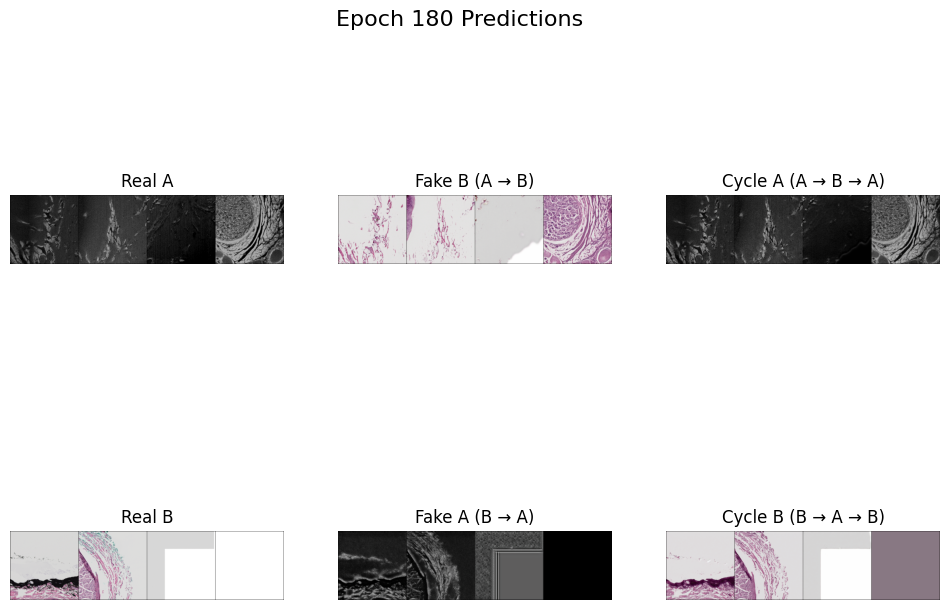

Epoch [181/200] Batch [0/72] - Gen Loss: 1.7090 (Adv: 0.7998, Cycle: 0.7458, Id: 0.2368) | Disc Loss: 0.3927 (D_A: 0.1889, D_B: 0.2038)
Epoch [181/200] Batch [10/72] - Gen Loss: 1.7778 (Adv: 0.9229, Cycle: 1.1096, Id: 0.4654) | Disc Loss: 0.4381 (D_A: 0.1834, D_B: 0.2547)
Epoch [181/200] Batch [20/72] - Gen Loss: 1.8819 (Adv: 0.9231, Cycle: 1.0509, Id: 0.4379) | Disc Loss: 0.3033 (D_A: 0.1320, D_B: 0.1713)
Epoch [181/200] Batch [30/72] - Gen Loss: 2.3751 (Adv: 0.9792, Cycle: 1.1014, Id: 0.4688) | Disc Loss: 0.2456 (D_A: 0.0913, D_B: 0.1543)
Epoch [181/200] Batch [40/72] - Gen Loss: 1.8168 (Adv: 1.0077, Cycle: 1.0473, Id: 0.4413) | Disc Loss: 0.3657 (D_A: 0.1528, D_B: 0.2128)
Epoch [181/200] Batch [50/72] - Gen Loss: 2.0025 (Adv: 1.0185, Cycle: 1.0369, Id: 0.4364) | Disc Loss: 0.3123 (D_A: 0.1501, D_B: 0.1622)
Epoch [181/200] Batch [60/72] - Gen Loss: 3.9688 (Adv: 1.0253, Cycle: 1.0134, Id: 0.4220) | Disc Loss: 0.2366 (D_A: 0.0624, D_B: 0.1743)
Epoch [181/200] Batch [70/72] - Gen Loss: 

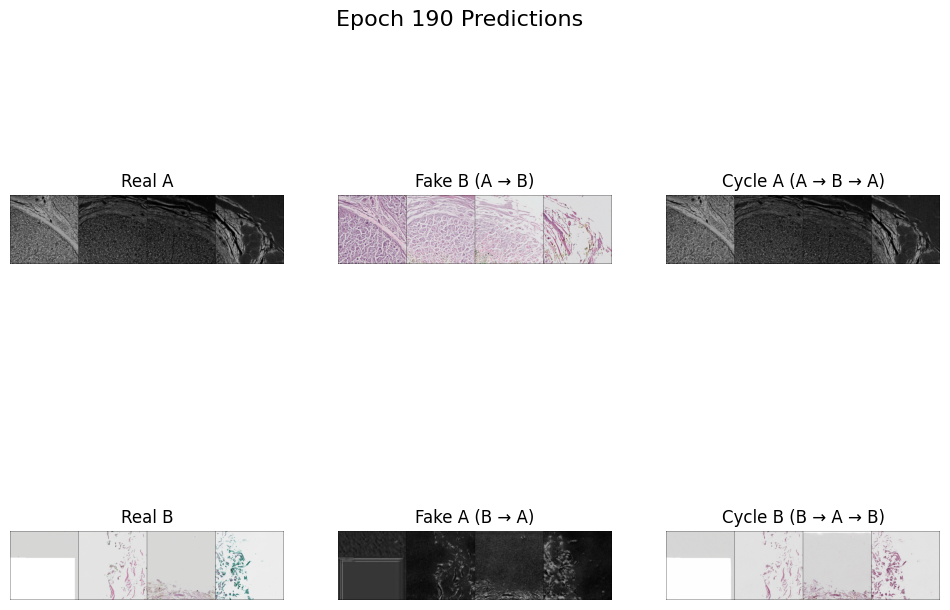

Epoch [191/200] Batch [0/72] - Gen Loss: 2.0311 (Adv: 0.8488, Cycle: 0.8810, Id: 0.3148) | Disc Loss: 0.3551 (D_A: 0.1649, D_B: 0.1902)
Epoch [191/200] Batch [10/72] - Gen Loss: 3.6183 (Adv: 0.8889, Cycle: 0.9528, Id: 0.3954) | Disc Loss: 0.3159 (D_A: 0.1650, D_B: 0.1509)
Epoch [191/200] Batch [20/72] - Gen Loss: 3.8774 (Adv: 0.9253, Cycle: 1.0064, Id: 0.4216) | Disc Loss: 0.3628 (D_A: 0.1782, D_B: 0.1846)
Epoch [191/200] Batch [30/72] - Gen Loss: 1.8332 (Adv: 0.9138, Cycle: 0.9627, Id: 0.4024) | Disc Loss: 0.4006 (D_A: 0.1719, D_B: 0.2287)
Epoch [191/200] Batch [40/72] - Gen Loss: 2.0308 (Adv: 0.9085, Cycle: 0.9068, Id: 0.3756) | Disc Loss: 0.3758 (D_A: 0.1875, D_B: 0.1883)
Epoch [191/200] Batch [50/72] - Gen Loss: 1.9463 (Adv: 0.8863, Cycle: 0.8859, Id: 0.3635) | Disc Loss: 0.3536 (D_A: 0.1233, D_B: 0.2303)
Epoch [191/200] Batch [60/72] - Gen Loss: 1.9645 (Adv: 0.8769, Cycle: 0.9206, Id: 0.3809) | Disc Loss: 0.3719 (D_A: 0.1696, D_B: 0.2023)
Epoch [191/200] Batch [70/72] - Gen Loss: 

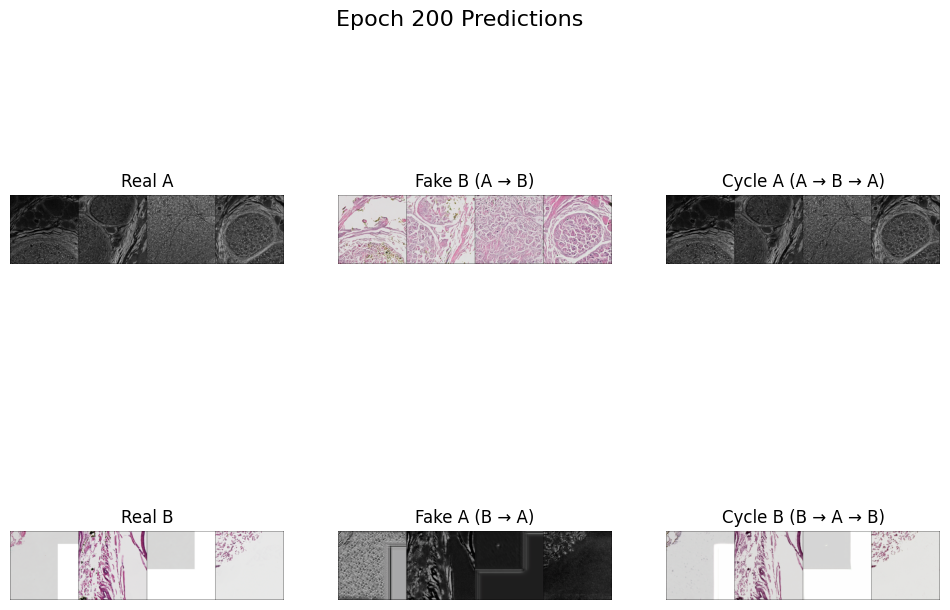

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os

# Instantiate the model and move to device.
MODEL_FILTERS = 64  # adjust as needed
model = CycleGAN(3, 3, MODEL_FILTERS).to(device)

# ---------------------
# Training Loss Setup
# ---------------------
criterion_GAN = AdversarialLoss()
criterion_cycle = nn.L1Loss()
criterion_idt = nn.L1Loss()
lambda_cycle = 10.0
lambda_idt = 0.5

# Optimizers for generators and discriminators.
optimizer_G = optim.Adam(
    list(model.G_A.parameters()) + list(model.G_B.parameters()),
    lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D = optim.Adam(
    list(model.D_A.parameters()) + list(model.D_B.parameters()),
    lr=0.0002, betas=(0.5, 0.999)
)

# Learning rate scheduler: constant for first n_epochs_static, then linear decay.
n_epochs = 200
n_epochs_static = 100

def lambda_rule(epoch):
    if epoch < n_epochs_static:
        return 1.0
    else:
        return 1.0 - (epoch - n_epochs_static) / (n_epochs - n_epochs_static)

scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)
scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=lambda_rule)

# Containers for logging overall losses.
epoch_loss_history_G = []       # Total generator loss.
epoch_loss_history_D = []       # Total discriminator loss.
epoch_lr_history_G = []
epoch_lr_history_D = []

# Containers for logging individual generator loss components.
epoch_loss_history_G_adv = []     # Adversarial loss.
epoch_loss_history_G_cycle = []   # Cycle consistency loss.
epoch_loss_history_G_idt = []     # Identity loss.

# Containers for logging discriminator loss components.
epoch_loss_history_D_A = []       # Discriminator A loss.
epoch_loss_history_D_B = []       # Discriminator B loss.

save_dir = '/content/drive/MyDrive/CycleGAN/checkpoints'  # update with your path.
os.makedirs(save_dir, exist_ok=True)

for epoch in range(n_epochs):
    model.train()
    loss_G_total_epoch = 0.0
    loss_D_total_epoch = 0.0
    loss_G_adv_total = 0.0
    loss_G_cycle_total = 0.0
    loss_G_idt_total = 0.0
    loss_D_A_total = 0.0
    loss_D_B_total = 0.0
    count = 0

    for i, (real_A, real_B) in enumerate(train_loader):
        # Scale images to [0,1] and move to device.
        real_A = real_A.to(device).float()
        real_B = real_B.to(device).float()

        # --------------- Train Generators ---------------
        optimizer_G.zero_grad()
        # Generate fake images.
        fake_B = model.G_A(real_A)  # A → B
        fake_A = model.G_B(real_B)  # B → A

        # Identity mapping.
        idt_A = model.G_B(real_A)
        idt_B = model.G_A(real_B)

        # Cycle consistency: reconstruct originals.
        cycle_A = model.G_B(fake_B)  # real_A -> fake_B -> cycle_A
        cycle_B = model.G_A(fake_A)  # real_B -> fake_A -> cycle_B

        # Discriminator predictions for adversarial loss.
        D_fake_A = model.D_A(fake_A)
        D_fake_B = model.D_B(fake_B)

        # Package outputs and targets.
        outputs = (fake_A, fake_B, idt_A, idt_B, cycle_A, cycle_B)
        targets = (real_A, real_B)

        # Compute full generator loss.
        loss_G = criterion_GAN(D_fake_B, True) + criterion_GAN(D_fake_A, True) \
                 + lambda_cycle * (criterion_cycle(cycle_A, real_A) + criterion_cycle(cycle_B, real_B)) \
                 + lambda_cycle * lambda_idt * (criterion_idt(idt_A, real_A) + criterion_idt(idt_B, real_B))
        loss_G.backward()
        optimizer_G.step()

        # --------------- Train Discriminators ---------------
        optimizer_D.zero_grad()
        loss_D_A = 0.5 * (criterion_GAN(model.D_A(real_A), True) +
                          criterion_GAN(model.D_A(fake_A.detach()), False))
        loss_D_B = 0.5 * (criterion_GAN(model.D_B(real_B), True) +
                          criterion_GAN(model.D_B(fake_B.detach()), False))
        loss_D = loss_D_A + loss_D_B
        loss_D.backward()
        optimizer_D.step()

        loss_G_total_epoch += loss_G.item()
        loss_D_total_epoch += loss_D.item()
        loss_G_adv_total += (criterion_GAN(model.D_A(fake_A), True) + criterion_GAN(model.D_B(fake_B), True)).item()
        loss_G_cycle_total += (criterion_cycle(cycle_A, real_A) + criterion_cycle(cycle_B, real_B)).item() * lambda_cycle
        loss_G_idt_total += (criterion_idt(idt_A, real_A) + criterion_idt(idt_B, real_B)).item() * lambda_cycle * lambda_idt
        loss_D_A_total += loss_D_A.item()
        loss_D_B_total += loss_D_B.item()
        count += 1

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}] Batch [{i}/{len(train_loader)}] - "
                  f"Gen Loss: {loss_G.item():.4f} (Adv: {loss_G_adv_total/count:.4f}, "
                  f"Cycle: {loss_G_cycle_total/count:.4f}, Id: {loss_G_idt_total/count:.4f}) | "
                  f"Disc Loss: {loss_D.item():.4f} (D_A: {loss_D_A.item():.4f}, D_B: {loss_D_B.item():.4f})")

    # Average losses over epoch.
    avg_loss_G = loss_G_total_epoch / count
    avg_loss_D = loss_D_total_epoch / count
    avg_loss_G_adv = loss_G_adv_total / count
    avg_loss_G_cycle = loss_G_cycle_total / count
    avg_loss_G_idt = loss_G_idt_total / count
    avg_loss_D_A = loss_D_A_total / count
    avg_loss_D_B = loss_D_B_total / count

    current_lr_G = optimizer_G.param_groups[0]['lr']
    current_lr_D = optimizer_D.param_groups[0]['lr']

    print(f"Epoch [{epoch+1}/{n_epochs}] finished: Avg Gen Loss = {avg_loss_G:.4f} "
          f"(Adv: {avg_loss_G_adv:.4f}, Cycle: {avg_loss_G_cycle:.4f}, Id: {avg_loss_G_idt:.4f}), "
          f"Avg Disc Loss = {avg_loss_D:.4f} (D_A: {avg_loss_D_A:.4f}, D_B: {avg_loss_D_B:.4f}), "
          f"LR_G = {current_lr_G:.6f}, LR_D = {current_lr_D:.6f}")

    epoch_loss_history_G.append(avg_loss_G)
    epoch_loss_history_D.append(avg_loss_D)
    epoch_lr_history_G.append(current_lr_G)
    epoch_lr_history_D.append(current_lr_D)
    epoch_loss_history_G_adv.append(avg_loss_G_adv)
    epoch_loss_history_G_cycle.append(avg_loss_G_cycle)
    epoch_loss_history_G_idt.append(avg_loss_G_idt)
    epoch_loss_history_D_A.append(avg_loss_D_A)
    epoch_loss_history_D_B.append(avg_loss_D_B)

    scheduler_G.step()
    scheduler_D.step()

    # Save model checkpoint and plot predictions every 5 epochs.
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch+1}.pth"))
        print(f"Saved checkpoint for epoch {epoch+1}.")

        model.eval()
        with torch.no_grad():
            sample_A, sample_B = next(iter(val_loader))
            sample_A = sample_A.to(device).float()
            sample_B = sample_B.to(device).float()

            fake_A, fake_B, _, _ = model((sample_A, sample_B))
            cycle_A = model.G_B(fake_B)
            cycle_B = model.G_A(fake_A)

            grid_real_A = make_grid(sample_A, nrow=4)
            grid_fake_B = make_grid(fake_B, nrow=4)
            grid_cycle_A = make_grid(cycle_A, nrow=4)
            grid_real_B = make_grid(sample_B, nrow=4)
            grid_fake_A = make_grid(fake_A, nrow=4)
            grid_cycle_B = make_grid(cycle_B, nrow=4)

            plt.figure(figsize=(12, 8))
            plt.subplot(2, 3, 1)
            plt.imshow(grid_real_A.permute(1, 2, 0).cpu().numpy())
            plt.title("Real A")
            plt.axis("off")

            plt.subplot(2, 3, 2)
            plt.imshow(grid_fake_B.permute(1, 2, 0).cpu().numpy())
            plt.title("Fake B (A → B)")
            plt.axis("off")

            plt.subplot(2, 3, 3)
            plt.imshow(grid_cycle_A.permute(1, 2, 0).cpu().numpy())
            plt.title("Cycle A (A → B → A)")
            plt.axis("off")

            plt.subplot(2, 3, 4)
            plt.imshow(grid_real_B.permute(1, 2, 0).cpu().numpy())
            plt.title("Real B")
            plt.axis("off")

            plt.subplot(2, 3, 5)
            plt.imshow(grid_fake_A.permute(1, 2, 0).cpu().numpy())
            plt.title("Fake A (B → A)")
            plt.axis("off")

            plt.subplot(2, 3, 6)
            plt.imshow(grid_cycle_B.permute(1, 2, 0).cpu().numpy())
            plt.title("Cycle B (B → A → B)")
            plt.axis("off")

            plt.suptitle(f"Epoch {epoch+1} Predictions", fontsize=16)
            plt.show()


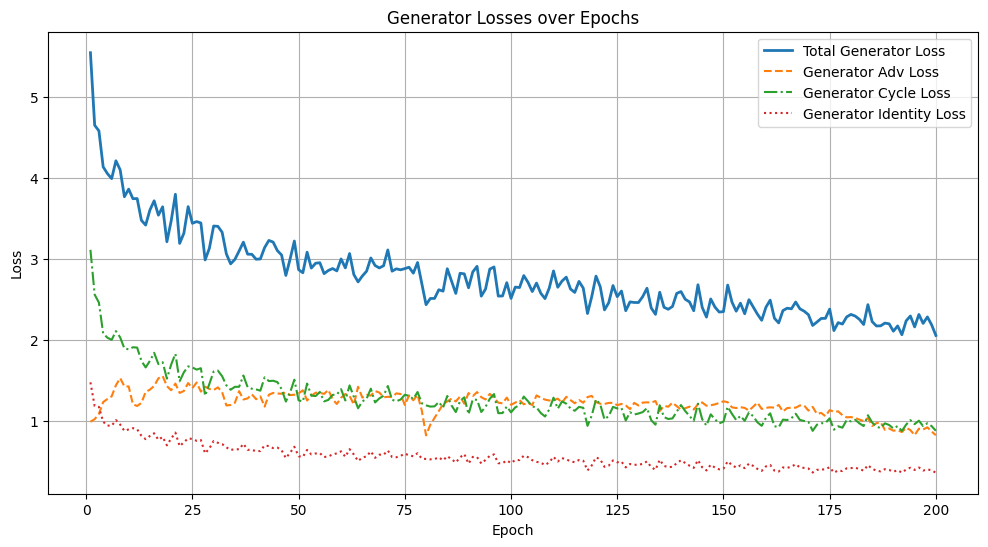

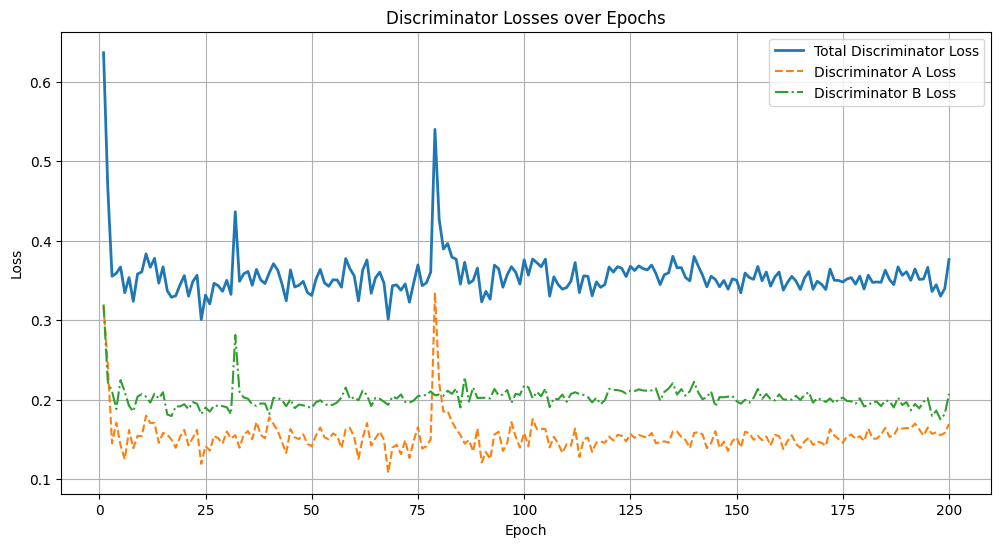

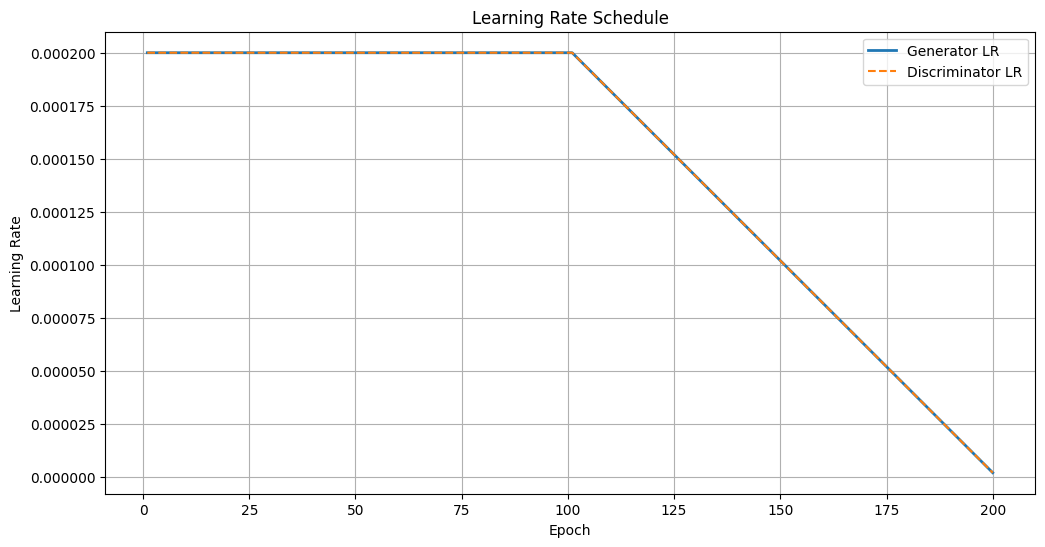

In [40]:
import matplotlib.pyplot as plt

epochs = range(1, n_epochs+1)

# Plot Generator Losses.
plt.figure(figsize=(12, 6))
plt.plot(epochs, epoch_loss_history_G, label='Total Generator Loss', linewidth=2)
plt.plot(epochs, epoch_loss_history_G_adv, label='Generator Adv Loss', linestyle='--')
plt.plot(epochs, epoch_loss_history_G_cycle, label='Generator Cycle Loss', linestyle='-.')
plt.plot(epochs, epoch_loss_history_G_idt, label='Generator Identity Loss', linestyle=':')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Losses over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot Discriminator Losses.
plt.figure(figsize=(12, 6))
plt.plot(epochs, epoch_loss_history_D, label='Total Discriminator Loss', linewidth=2)
plt.plot(epochs, epoch_loss_history_D_A, label='Discriminator A Loss', linestyle='--')
plt.plot(epochs, epoch_loss_history_D_B, label='Discriminator B Loss', linestyle='-.')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Losses over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot Learning Rate Schedule.
plt.figure(figsize=(12, 6))
plt.plot(epochs, epoch_lr_history_G, label='Generator LR', linewidth=2)
plt.plot(epochs, epoch_lr_history_D, label='Discriminator LR', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


In [46]:
def evaluate_cycleGAN(model, test_loader, device,
                      lambda_cycle=10.0, lambda_idt=0.5,
                      criterion_GAN=None, criterion_cycle=None, criterion_idt=None):
    """
    Evaluates the CycleGAN model over the entire test dataset.

    Args:
        model (nn.Module): Trained CycleGAN model.
        test_loader (DataLoader): Test DataLoader returning (real_A, real_B).
        device (torch.device): Device (CPU or CUDA).
        lambda_cycle (float): Weight for cycle consistency loss.
        lambda_idt (float): Weight for identity loss.
        criterion_GAN (nn.Module): Adversarial loss function (e.g., MSELoss wrapped in AdversarialLoss).
        criterion_cycle (nn.Module): Cycle consistency loss (e.g., L1Loss).
        criterion_idt (nn.Module): Identity loss (e.g., L1Loss).

    Returns:
        losses (dict): Dictionary containing average loss metrics.
    """
    model.eval()
    total_loss_G = 0.0
    total_loss_D = 0.0
    total_loss_G_adv = 0.0
    total_loss_G_cycle = 0.0
    total_loss_G_idt = 0.0
    total_loss_D_A = 0.0
    total_loss_D_B = 0.0
    count = 0

    with torch.no_grad():
        for real_A, real_B in test_loader:
            # Scale images to [0,1] and move to device.
            real_A = real_A.to(device).float()
            real_B = real_B.to(device).float()

            # Generator forward pass.
            fake_B = model.G_A(real_A)  # A → B.
            fake_A = model.G_B(real_B)  # B → A.

            # Identity mappings.
            idt_A = model.G_B(real_A)
            idt_B = model.G_A(real_B)

            # Cycle consistency: reconstruct originals.
            cycle_A = model.G_B(fake_B)  # real_A -> fake_B -> cycle_A.
            cycle_B = model.G_A(fake_A)  # real_B -> fake_A -> cycle_B.

            # Adversarial losses for generators.
            loss_GAN_A2B = criterion_GAN(model.D_B(fake_B), True)
            loss_GAN_B2A = criterion_GAN(model.D_A(fake_A), True)
            loss_GAN = loss_GAN_A2B + loss_GAN_B2A

            # Cycle consistency losses.
            loss_cycle_A = criterion_cycle(cycle_A, real_A)
            loss_cycle_B = criterion_cycle(cycle_B, real_B)
            loss_cycle = (loss_cycle_A + loss_cycle_B) * lambda_cycle

            # Identity losses.
            loss_idt_A = criterion_idt(idt_A, real_A) * lambda_cycle * lambda_idt
            loss_idt_B = criterion_idt(idt_B, real_B) * lambda_cycle * lambda_idt
            loss_idt = loss_idt_A + loss_idt_B

            # Total generator loss.
            loss_G = loss_GAN + loss_cycle + loss_idt

            # Discriminator losses.
            loss_D_A = 0.5 * (criterion_GAN(model.D_A(real_A), True) +
                              criterion_GAN(model.D_A(fake_A.detach()), False))
            loss_D_B = 0.5 * (criterion_GAN(model.D_B(real_B), True) +
                              criterion_GAN(model.D_B(fake_B.detach()), False))
            loss_D = loss_D_A + loss_D_B

            # Accumulate losses.
            total_loss_G += loss_G.item()
            total_loss_D += loss_D.item()
            total_loss_G_adv += loss_GAN.item()
            total_loss_G_cycle += loss_cycle.item()
            total_loss_G_idt += loss_idt.item()
            total_loss_D_A += loss_D_A.item()
            total_loss_D_B += loss_D_B.item()
            count += 1

    avg_loss_G = total_loss_G / count if count > 0 else 0
    avg_loss_D = total_loss_D / count if count > 0 else 0
    avg_loss_G_adv = total_loss_G_adv / count if count > 0 else 0
    avg_loss_G_cycle = total_loss_G_cycle / count if count > 0 else 0
    avg_loss_G_idt = total_loss_G_idt / count if count > 0 else 0
    avg_loss_D_A = total_loss_D_A / count if count > 0 else 0
    avg_loss_D_B = total_loss_D_B / count if count > 0 else 0

    print(f"Test Results over {count} batches:")
    print(f"  Avg Generator Loss: {avg_loss_G:.4f}")
    print(f"      - Adv Loss: {avg_loss_G_adv:.4f}")
    print(f"      - Cycle Loss: {avg_loss_G_cycle:.4f}")
    print(f"      - Identity Loss: {avg_loss_G_idt:.4f}")
    print(f"  Avg Discriminator Loss: {avg_loss_D:.4f}")
    print(f"      - D_A Loss: {avg_loss_D_A:.4f}")
    print(f"      - D_B Loss: {avg_loss_D_B:.4f}")

    losses = {
        "avg_loss_G": avg_loss_G,
        "avg_loss_D": avg_loss_D,
        "avg_loss_G_adv": avg_loss_G_adv,
        "avg_loss_G_cycle": avg_loss_G_cycle,
        "avg_loss_G_idt": avg_loss_G_idt,
        "avg_loss_D_A": avg_loss_D_A,
        "avg_loss_D_B": avg_loss_D_B
    }
    return losses

# Example usage:
# Ensure test_loader, model, device, lambda values, and loss functions are defined.
loss_metrics = evaluate_cycleGAN(
    model, test_loader, device,
    lambda_cycle=lambda_cycle, lambda_idt=lambda_idt,
    criterion_GAN=criterion_GAN, criterion_cycle=criterion_cycle, criterion_idt=criterion_idt
)


Test Results over 16 batches:
  Avg Generator Loss: 2.3102
      - Adv Loss: 0.8685
      - Cycle Loss: 1.0126
      - Identity Loss: 0.4291
  Avg Discriminator Loss: 0.3741
      - D_A Loss: 0.1591
      - D_B Loss: 0.2150


Loading model checkpoint from /content/drive/MyDrive/CycleGAN/checkpoints/model_epoch_200.pth ...
Model loaded.


<ipython-input-48-9efa1814d7ff>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)


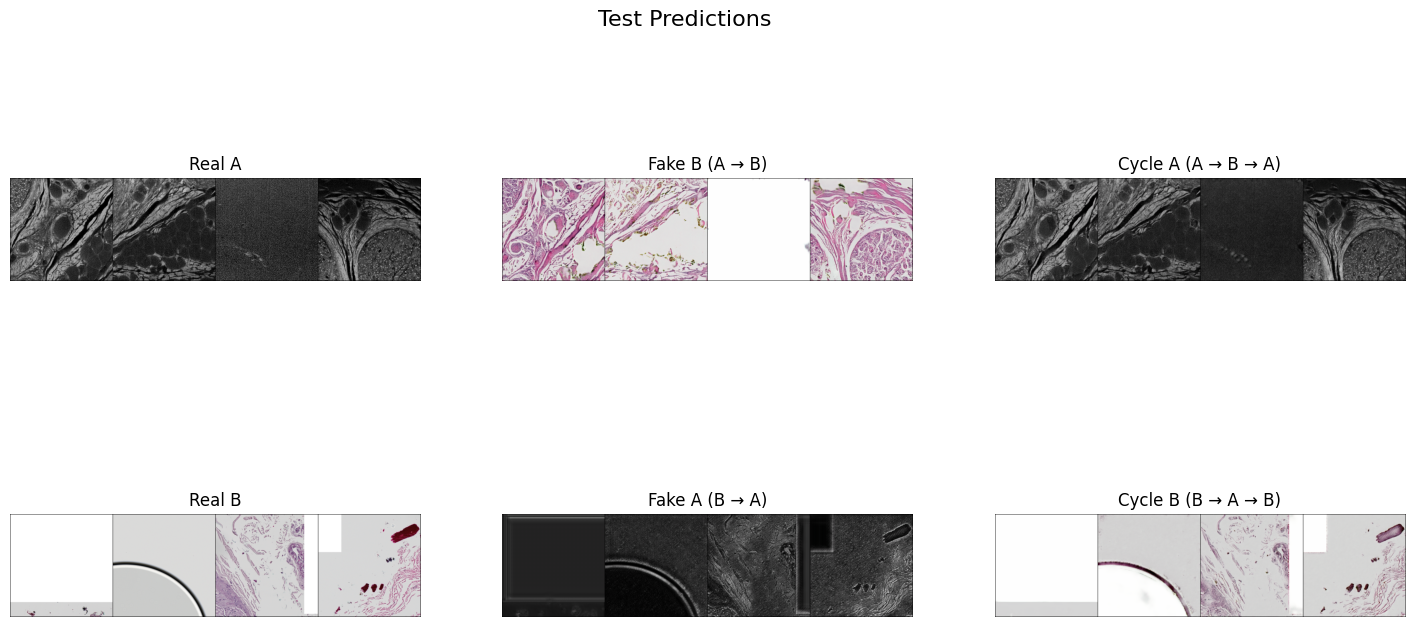

In [48]:
import torch
import os
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Define your CycleGAN, AdversarialLoss, etc. here or import them.

def load_model(model, checkpoint_path, device):
    """
    Loads model weights from a checkpoint and moves the model to device.
    """
    if os.path.isfile(checkpoint_path):
        print(f"Loading model checkpoint from {checkpoint_path} ...")
        state_dict = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(state_dict)
        model.to(device)
        print("Model loaded.")
    else:
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    return model

def plot_predictions(model, dataloader, device):
    """
    Fetch one batch from the dataloader, run the model to generate translations,
    and display predictions in a 2x3 grid.
    """
    model.eval()
    with torch.no_grad():
        sample_A, sample_B = next(iter(dataloader))
        sample_A = sample_A.to(device).float()
        sample_B = sample_B.to(device).float()

        # Forward pass: fake images.
        fake_A, fake_B, _, _ = model((sample_A, sample_B))
        cycle_A = model.G_B(fake_B)
        cycle_B = model.G_A(fake_A)

        grid_real_A = make_grid(sample_A, nrow=4)
        grid_fake_B = make_grid(fake_B, nrow=4)
        grid_cycle_A = make_grid(cycle_A, nrow=4)
        grid_real_B = make_grid(sample_B, nrow=4)
        grid_fake_A = make_grid(fake_A, nrow=4)
        grid_cycle_B = make_grid(cycle_B, nrow=4)

        plt.figure(figsize=(18, 8))
        plt.subplot(2, 3, 1)
        plt.imshow(grid_real_A.permute(1, 2, 0).cpu().numpy())
        plt.title("Real A")
        plt.axis("off")

        plt.subplot(2, 3, 2)
        plt.imshow(grid_fake_B.permute(1, 2, 0).cpu().numpy())
        plt.title("Fake B (A → B)")
        plt.axis("off")

        plt.subplot(2, 3, 3)
        plt.imshow(grid_cycle_A.permute(1, 2, 0).cpu().numpy())
        plt.title("Cycle A (A → B → A)")
        plt.axis("off")

        plt.subplot(2, 3, 4)
        plt.imshow(grid_real_B.permute(1, 2, 0).cpu().numpy())
        plt.title("Real B")
        plt.axis("off")

        plt.subplot(2, 3, 5)
        plt.imshow(grid_fake_A.permute(1, 2, 0).cpu().numpy())
        plt.title("Fake A (B → A)")
        plt.axis("off")

        plt.subplot(2, 3, 6)
        plt.imshow(grid_cycle_B.permute(1, 2, 0).cpu().numpy())
        plt.title("Cycle B (B → A → B)")
        plt.axis("off")

        plt.suptitle("Test Predictions", fontsize=16)
        plt.show()

# Example testing script.
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize your model architecture.
    MODEL_FILTERS = 64
    model = CycleGAN(3, 3, MODEL_FILTERS).to(device)

    # Path to the checkpoint to load.
    checkpoint_path = "/content/drive/MyDrive/CycleGAN/checkpoints/model_epoch_200.pth"  # update as needed.
    model = load_model(model, checkpoint_path, device)

    # Run inference on the test set.
    plot_predictions(model, test_loader, device)

Loading checkpoint from /content/drive/MyDrive/CycleGAN/checkpoints/model_epoch_200.pth...
Model loaded.
Processing file: /content/drive/MyDrive/CycleGAN/split_dataset_A/test/processed_slice_316_tiles.tiff


<ipython-input-49-1fef0062f01d>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)


Note: /content/drive/MyDrive/CycleGAN/split_dataset_A/test/processed_slice_316_tiles.tiff is grayscale; converting to RGB.
Saved translated image to /content/drive/MyDrive/CycleGAN/inference_3/translated_processed_slice_316_tiles.tiff
Processing file: /content/drive/MyDrive/CycleGAN/split_dataset_A/test/processed_slice_321_tiles.tiff
Note: /content/drive/MyDrive/CycleGAN/split_dataset_A/test/processed_slice_321_tiles.tiff is grayscale; converting to RGB.
Saved translated image to /content/drive/MyDrive/CycleGAN/inference_3/translated_processed_slice_321_tiles.tiff
Processing file: /content/drive/MyDrive/CycleGAN/split_dataset_A/test/processed_slice_150_tiles.tiff
Note: /content/drive/MyDrive/CycleGAN/split_dataset_A/test/processed_slice_150_tiles.tiff is grayscale; converting to RGB.
Saved translated image to /content/drive/MyDrive/CycleGAN/inference_3/translated_processed_slice_150_tiles.tiff
Processing file: /content/drive/MyDrive/CycleGAN/split_dataset_A/test/processed_slice_282_til

Saved translated image to /content/drive/MyDrive/CycleGAN/inference_3/translated_processed_slice_327_tiles.tiff


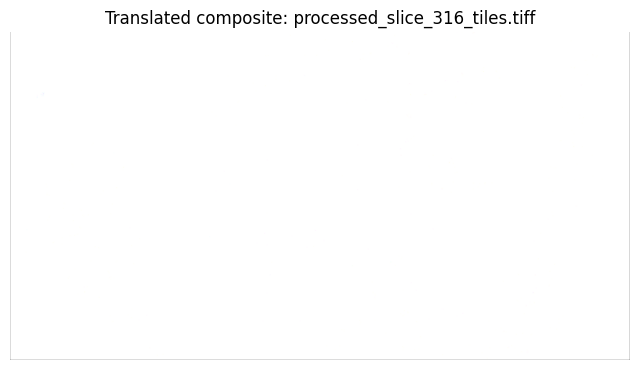

In [49]:
import os
import glob
import torch
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

####################################
# Stitching Utilities
####################################

def infer_grid_shape(n_tiles, orig_shape=None, tile_size=(512,512), overlap=(256,256)):
    tile_h, tile_w = tile_size
    ov_h, ov_w = overlap
    stride_h = tile_h - ov_h
    stride_w = tile_w - ov_w

    if orig_shape is not None:
        orig_height, orig_width = orig_shape
        grid_rows = (orig_height - tile_h) // stride_h + 1
        grid_cols = (orig_width  - tile_w) // stride_w + 1
        if grid_rows * grid_cols == n_tiles:
            return grid_rows, grid_cols

    best = None
    for r in range(1, n_tiles+1):
        if n_tiles % r == 0:
            c = n_tiles // r
            diff = abs(r - c)
            if best is None or diff < best[0]:
                best = (diff, r, c)
    if best is None:
        return (n_tiles, 1)
    else:
        return (best[1], best[2])

def stitch_processed_tile_stack(tiles, tile_size=(512,512), overlap=(256,256)):
    """
    Given a NumPy array of processed tiles (shape: (n_tiles, tile_h, tile_w, 3)),
    stitch them into a composite image using weighted blending.
    """
    n_tiles, th, tw, ch = tiles.shape
    grid_shape = infer_grid_shape(n_tiles, tile_size=tile_size, overlap=overlap)
    n_rows, n_cols = grid_shape
    if n_rows * n_cols != n_tiles:
        print(f"Warning: Inferred grid shape {grid_shape} does not multiply to n_tiles {n_tiles}.")

    stride_h = tile_size[0] - overlap[0]
    stride_w = tile_size[1] - overlap[1]
    out_height = (n_rows - 1) * stride_h + tile_size[0]
    out_width  = (n_cols - 1) * stride_w + tile_size[1]

    stitched = np.zeros((out_height, out_width, ch), dtype=np.float32)
    weight = np.zeros((out_height, out_width, ch), dtype=np.float32)

    win_y = np.hanning(tile_size[0])
    win_x = np.hanning(tile_size[1])
    window = np.outer(win_y, win_x)[..., np.newaxis]

    tile_idx = 0
    for i in range(n_rows):
        for j in range(n_cols):
            tile = tiles[tile_idx].astype(np.float32)
            top = i * stride_h
            left = j * stride_w
            stitched[top:top+tile_size[0], left:left+tile_size[1], :] += tile * window
            weight[top:top+tile_size[0], left:left+tile_size[1], :] += window
            tile_idx += 1

    weight[weight == 0] = 1
    stitched /= weight
    return stitched

####################################
# Model Loading and Inference Functions
####################################

def load_model(model, checkpoint_path, device):
    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}...")
        state_dict = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(state_dict)
        model.to(device)
        print("Model loaded.")
    else:
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    return model

def run_inference_on_tile_stack(model, tiff_path, device, tile_size=(512,512), overlap=(256,256)):
    """
    Given a tile stack TIFF file (Domain A), run inference on each tile (patch) individually
    using generator G_A (translating Domain A → Domain B), then stitch the translated patches together.

    Returns:
        composite_translated (np.ndarray): The stitched composite translated image (as 16-bit).
    """
    # Read the tile stack.
    tiles = tiff.imread(tiff_path)
    # If the tile stack is grayscale (3D), replicate the channel to get RGB.
    if tiles.ndim == 3:
        print(f"Note: {tiff_path} is grayscale; converting to RGB.")
        tiles = np.stack([tiles] * 3, axis=-1)
    elif tiles.ndim != 4:
        raise ValueError("Expected tile stack with shape (n_tiles, tile_h, tile_w, 3)")

    n_tiles, th, tw, ch = tiles.shape
    translated_tiles = []

    # Process each tile individually.
    for i in range(n_tiles):
        tile = tiles[i]  # shape: (tile_h, tile_w, 3)
        # Convert to tensor: (H, W, 3) uint8 -> (1, 3, H, W) float in [0,1].
        tile_tensor = torch.from_numpy(tile).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        tile_tensor = tile_tensor.to(device)
        # Run inference using generator G_A (Domain A → Domain B).
        fake_tile = model.G_A(tile_tensor)
        # Since generator output is assumed to be in [0,1], we detach and convert to NumPy.
        fake_tile_np = fake_tile.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
        translated_tiles.append(fake_tile_np)

    # Stack translated tiles to shape (n_tiles, tile_h, tile_w, 3)
    translated_tiles = np.stack(translated_tiles, axis=0)
    # Stitch the translated tiles.
    composite_translated = stitch_processed_tile_stack(translated_tiles, tile_size=tile_size, overlap=overlap)

    # Convert composite image to 16-bit: scale from [0,1] to [0,65535].
    composite_translated = (composite_translated * 65535).astype(np.uint16)
    return composite_translated

def run_inference_A_to_B(model, folder, device, output_dir=None, tile_size=(512,512), overlap=(256,256)):
    """
    For each tile stack TIFF in the folder (Domain A), run inference on each patch,
    stitch the translated patches into a composite image, and save the result as a 16-bit image.

    Returns:
        results (dict): Mapping of file basename to its composite translated image.
    """
    files = glob.glob(os.path.join(folder, "*.tiff")) + glob.glob(os.path.join(folder, "*.tif"))
    results = {}

    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)

    for f in files:
        try:
            print(f"Processing file: {f}")
            translated_composite = run_inference_on_tile_stack(model, f, device, tile_size=tile_size, overlap=overlap)
            basename = os.path.basename(f)
            results[basename] = translated_composite
            if output_dir is not None:
                out_file = os.path.join(output_dir, f"translated_{basename}")
                tiff.imwrite(out_file, translated_composite)
                print(f"Saved translated image to {out_file}")
        except Exception as e:
            print(f"Error processing file {f}: {e}")
    return results

####################################
# Example Usage
####################################
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate and load your CycleGAN model.
    MODEL_FILTERS = 64
    model = CycleGAN(3, 3, MODEL_FILTERS).to(device)
    checkpoint_path = "/content/drive/MyDrive/CycleGAN/checkpoints/model_epoch_200.pth"  # Update this path.
    # Specify the input folder containing tile stack TIFF files.
    folder  = "/content/drive/MyDrive/CycleGAN/split_dataset_A/test"
    # Specify the output folder to save composite images.
    output_dir = "/content/drive/MyDrive/CycleGAN/inference_3"
    model = load_model(model, checkpoint_path, device)

    # Run inference (Domain A → Domain B) on each tile stack.
    translated_images = run_inference_A_to_B(
        model, folder, device,
        output_dir=output_dir,
        tile_size=(512,512), overlap=(256,256)
    )

    # Optionally, display one of the translated composite images.
    sample_key = list(translated_images.keys())[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(translated_images[sample_key])
    plt.title(f"Translated composite: {sample_key}")
    plt.axis("off")
    plt.show()


In [ ]:
checkpoint_path = "/content/drive/MyDrive/CycleGAN/checkpoints/model_epoch_200.pth"  # Update this path.
# Specify the input folder containing tile stack TIFF files.
folder  = "/content/drive/MyDrive/CycleGAN/split_dataset_A/test"
# Specify the output folder to save composite images.
out_folder = "/content/drive/MyDrive/CycleGAN/inference_3"